In [0]:
import pyspark
from pyspark.sql.functions import sum,avg,max,min,mean,count,col,lit,to_timestamp,collect_list,arrays_zip,udf
from pyspark.sql.types import StringType,FloatType,DateType,BooleanType,StructType,StructField,IntegerType
from pyspark import StorageLevel
import matplotlib.pyplot as plt
import numpy as np
import datetime
from shapely.geometry import Polygon, LineString
import os


In [0]:
today = datetime.date.today()

In [0]:
dates = [today - datetime.timedelta(days=ago) for ago in range(21, 20, -1)]
dates

Out[27]: [datetime.date(2022, 6, 24)]

In [0]:
run_id = datetime.datetime.today().strftime("%Y%m%d-%H%M%S")

In [0]:
bucket = "com-elsevier-recs-dev-experiments"
user = "lyner"
# subset = "AIS_2022_03_2"

In [0]:
AIS_STATUS = [
  "under way using engine",
  "at anchor",
  "not under command ",
  "restricted maneuverability",
  "constrained by her draught",
  "moored",
  "aground ",
  "engaged in fishing",
  "under way sailing",
  "reserved for future amendment of navigational status for ships carrying DG, HS, or MP, or IMO hazard or pollutant category C, high-speed craft (HSC)",
  "reserved for future amendment of navigational status for ships carrying dangerous goods (DG), harmful substances (HS) or marine pollutants (MP), or IMO hazard or pollutant category A, wing in ground (WIG)",
  "power-driven vessel towing astern (regional use)",
  "power-driven vessel pushing ahead or towing alongside (regional use)",
  "reserved for future use",
  "AIS-SART (active), MOB-AIS, EPIRB-AIS",
  "undefined = default (also used by AIS-SART, MOB-AIS and EPIRB-AIS under test)"
]

FISHING_AIS_STATUS_CODE = 7

AIS_STATUS_CODES = [(count, value) for count, value in enumerate(AIS_STATUS)]
ais_statuses = spark.createDataFrame(data=AIS_STATUS_CODES, schema = ["status_code","status_message"])

In [0]:
ais_messages_path = "s3://%s/%s/noaa/ais/" %(bucket, user)
fishing_vessel_ais_messages_path = "s3://%s/%s/noaa/fishing-vessel-ais/%s/data" %(bucket, user, run_id)
fishing_vessel_ais_messages_parquet_path = "s3://%s/%s/noaa/fishing-vessel-ais-parquet/%s/data" %(bucket, user, run_id)
sample_fishing_vessel_ais_messages_path = "s3://%s/%s/noaa/fishing-vessel-ais-sample/%s/data" %(bucket, user, run_id)
marine_conservation_areas_path = "s3://%s/%s/marine-conservation-areas/us-marine-protection-areas.csv" %(bucket, user)
intersecting_fishing_matrix_path = "s3://%s/%s/fishing-matrix-intersects/%s/data/fishing-matrix-intersects.csv" %(bucket, user, run_id)
intersecting_fishing_matrix_parquet_path = "s3://%s/%s/fishing-matrix-intersects-parquet/%s/data/" %(bucket, user, run_id)


In [0]:
ais_messages = spark.read.option("header", "true").csv(ais_messages_path).persist(StorageLevel.MEMORY_ONLY)
# ais_message_mmsi_freq = ais_messages.groupBy("MMSI").count().orderBy(col("count").desc())

Use the AIS status code to filter out vessels stating they are fishing at some point...

In [0]:
# mmsi_of_vessels_with_fishing_status = ais_messages \
#   .filter(col("status") == lit(FISHING_AIS_STATUS_CODE)) \
#   .select(col("MMSI")) \
#   .distinct() \
#   .persist(StorageLevel.MEMORY_ONLY)

# renamed_mmsi_of_vessels_with_fishing_status = mmsi_of_vessels_with_fishing_status.withColumnRenamed("MMSI","mmsi_only")

fishing_vessel_ais_messages = ais_messages # \
#   .join(renamed_mmsi_of_vessels_with_fishing_status, ais_messages.MMSI == renamed_mmsi_of_vessels_with_fishing_status.mmsi_only) \
#   .drop("mmsi_only") \
#   .distinct() \
#   .persist(StorageLevel.MEMORY_ONLY)


In [0]:
fishing_vessel_ais_messages.write.option("header","true").csv(fishing_vessel_ais_messages_path)
fishing_vessel_ais_messages.write.parquet(fishing_vessel_ais_messages_parquet_path)

In [0]:
# fishing_vessel_ais_messages.groupBy("MMSI").count().orderBy(col("count").desc()).show(truncate = False)

In [0]:
# fishing_vessel_ais_messages.filter(col("MMSI") == lit(367407440)).show(truncate = False)

In [0]:
# count_statuses = fishing_vessel_ais_messages.groupBy(col("status")).count().orderBy(col("count").desc())

In [0]:
# count_statuses.join(ais_statuses, count_statuses.status == ais_statuses.status_code).drop("status_code").orderBy(col("count").desc()).show(truncate=False)

In [0]:
fishing_vessel_statuses_freq = fishing_vessel_ais_messages.groupBy(col("MMSI"), col("status")).count().orderBy(col("MMSI"), col("count").desc())
fishing_vessel_statuses_freq_expanded_status = fishing_vessel_statuses_freq.join(ais_statuses, fishing_vessel_statuses_freq.status == ais_statuses.status_code).drop("status_code").orderBy(col("MMSI"), col("status")).persist(StorageLevel.MEMORY_ONLY)

count_fishing_vessel_statuses_freq_expanded_status = fishing_vessel_statuses_freq_expanded_status.count()
count_fishing_vessel_statuses_freq_expanded_status

In [0]:
# fishing_vessel_statuses_freq_expanded_status.show(n=201, truncate=False)

In [0]:
sample_vessel = "367709890"
sample_fishing_vessel_ais_messages = fishing_vessel_ais_messages.filter(col("MMSI") == lit(sample_vessel))
sample_fishing_vessel_ais_messages.write.option("header", "true").csv(sample_fishing_vessel_ais_messages_path)

In [0]:
# sample_fishing_vessel_ais_messages.show()

In [0]:
@udf("array<struct<_1:double,_2:double>>")
def zip_(xs, ys):
    return list(zip(xs, ys))

  
def ais_messages_to_route(df):
  return df.withColumn("y",col("LAT").cast(FloatType())) \
    .withColumn("x",col("LON").cast(FloatType())) \
    .withColumn("time",to_timestamp("BaseDateTime")) \
    .withColumnRenamed("MMSI", "mmsi") \
    .select("mmsi", "y", "x", "time") \
    .orderBy("mmsi", "time") \
    .drop("time") \
    .groupBy("mmsi") \
    .agg(collect_list("x"), collect_list("y")) \
    .withColumnRenamed("collect_list(x)", "x") \
    .withColumnRenamed("collect_list(y)", "y") \
    .withColumn("route", arrays_zip("x", "y")) \
    .drop("x", "y") \
    
  
sample_fishing_vessel_route_df = ais_messages_to_route(sample_fishing_vessel_ais_messages).persist(StorageLevel.MEMORY_ONLY)


In [0]:
fishing_vessels_route_df = ais_messages_to_route(fishing_vessel_ais_messages).persist(StorageLevel.MEMORY_ONLY)

In [0]:
fishing_vessels_route_df.show(truncate=True)

In [0]:

sample_fishing_vessel_route = sample_fishing_vessel_route_df.collect()

In [0]:
def marine_protected_area_boundary_points(df):
  return df \
    .orderBy("name", "point") \
    .drop("point") \
    .groupBy("name") \
    .agg(collect_list("Lon"), collect_list("Lat")) \
    .withColumnRenamed("collect_list(Lon)", "x") \
    .withColumnRenamed("collect_list(Lat)", "y") \
    .withColumn("coords", arrays_zip("x", "y")) \
    .drop("x", "y")


custom_schema = StructType([ \
    StructField("name", StringType()), \
    StructField("point", IntegerType()), \
    StructField("Lon", FloatType()), \
    StructField("Lat", FloatType()) \
])
marine_conservation_areas_df = marine_protected_area_boundary_points(spark.read.option("header", "true").schema(custom_schema).csv(marine_conservation_areas_path))


In [0]:
marine_conservation_areas_df.show(truncate=False)

In [0]:
ais_messages.select("MMSI").distinct().count()

In [0]:
fishing_matrix = fishing_vessels_route_df.join(marine_conservation_areas_df)

In [0]:
# @udf("array<struct<_1:double,_2:double>>,array<struct<_1:double,_2:double>>")
def is_intersect(route, area):
  is_intersect = False
  if len(route) > 1:
    shape_route = LineString(route)
    shape_area = Polygon(area)
    is_intersect = shape_area.intersects(shape_route)
  return is_intersect

udf_is_intersect = udf(is_intersect, BooleanType())


intersecting_fishing_matrix = fishing_matrix.filter(udf_is_intersect("route", "coords"))

In [0]:
intersecting_fishing_matrix.write.parquet(intersecting_fishing_matrix_parquet_path)

In [0]:
# Use this to reload rather than constructing the whole thing
run_id = "20220710-223039"
intersecting_fishing_matrix = spark.read.parquet(intersecting_fishing_matrix_parquet_path)

In [0]:
import io
import s3fs

s3_or_dbfs = ""
# s3_or_dbfs = "s3"
# s3_or_dbfs = "dbfs"

def save_plot(plt, mmsi, area_name):
  if s3_or_dbfs == "s3":
    plot_path = "s3://%s/%s/output/plot-paths/%s/data" %(bucket, user, run_id)
    mmsi_area_plot_path = "%s/%s-%s.png" % (plot_path, mmsi, area_name)
    img_data = io.BytesIO()
    plt.savefig(img_data, format='png', bbox_inches='tight', pand_inches=1)
    img_data.seek(0)
    s3 = s3fs.S3FileSystem(anon=False, s3_additional_kwargs={'ServerSideEncryption': 'AES256'})  # Uses default credentials
    with s3.open(mmsi_area_plot_path, 'wb') as f:
        f.write(img_data.getbuffer())
  elif s3_or_dbfs == "dbfs":
    mmsi_area_plot_path = "dbfs:/dbfs/%s/plot-paths/%s/data/%s-%s.png" % (user, run_id, mmsi, area_name)
    os.mkdir(mmsi_area_plot_path)
    plt.savefig(mmsi_area_plot_path)
  
        

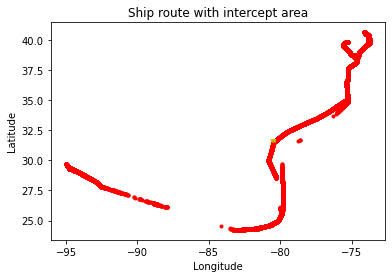

route of mmsi '367036000' intersects marine_conservation_area 'Georgia'


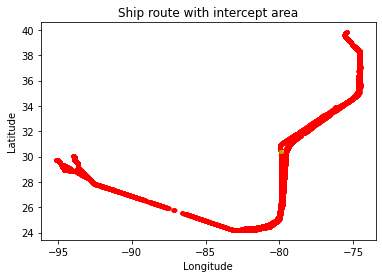

route of mmsi '367353110' intersects marine_conservation_area 'North Florida'


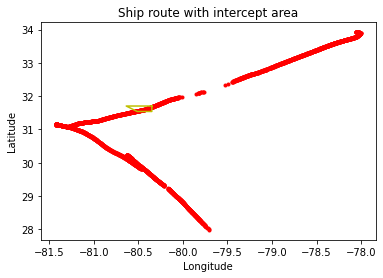

route of mmsi '368199330' intersects marine_conservation_area 'Georgia'


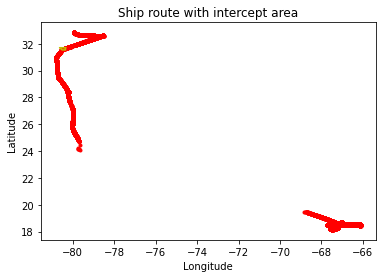

route of mmsi '369912000' intersects marine_conservation_area 'Georgia'


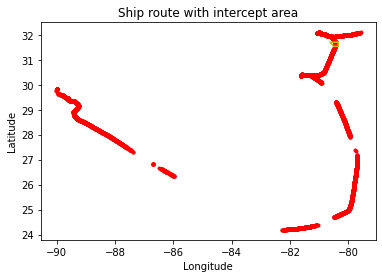

route of mmsi '259890000' intersects marine_conservation_area 'Georgia'


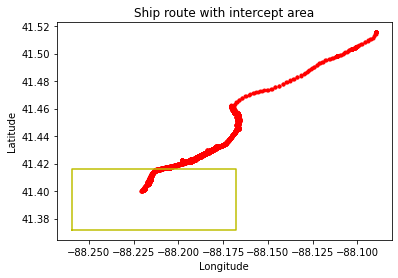

route of mmsi '367476930' intersects marine_conservation_area 'Demo'


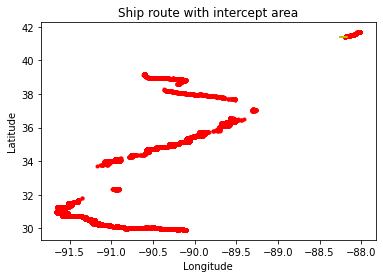

route of mmsi '367645970' intersects marine_conservation_area 'Demo'


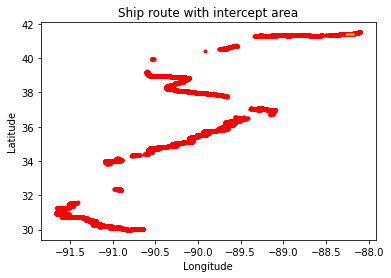

route of mmsi '367690430' intersects marine_conservation_area 'Demo'


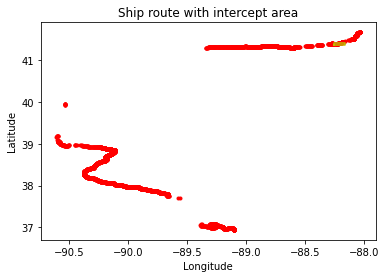

route of mmsi '367638260' intersects marine_conservation_area 'Demo'


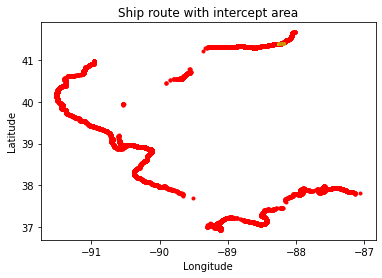

route of mmsi '367779120' intersects marine_conservation_area 'Demo'


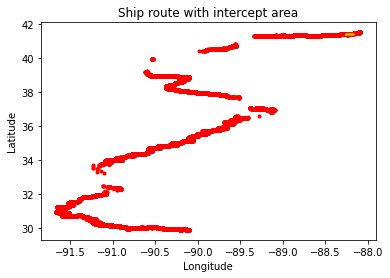

route of mmsi '368215660' intersects marine_conservation_area 'Demo'


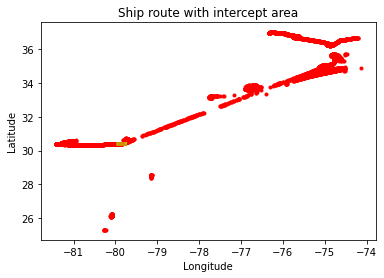

route of mmsi '999999999' intersects marine_conservation_area 'North Florida'


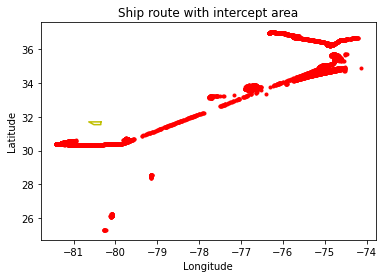

route of mmsi '999999999' intersects marine_conservation_area 'Georgia'


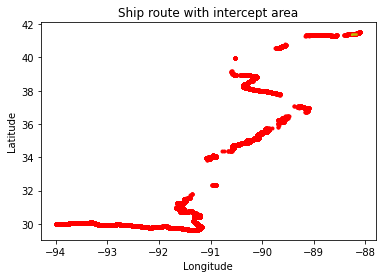

route of mmsi '367361740' intersects marine_conservation_area 'Demo'


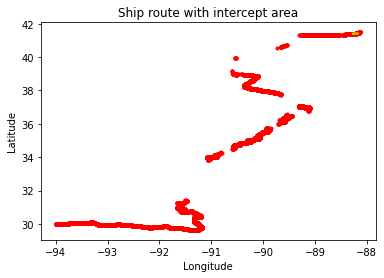

route of mmsi '367525060' intersects marine_conservation_area 'Demo'


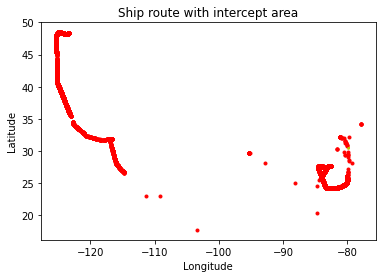

route of mmsi '636018146' intersects marine_conservation_area 'North Florida'


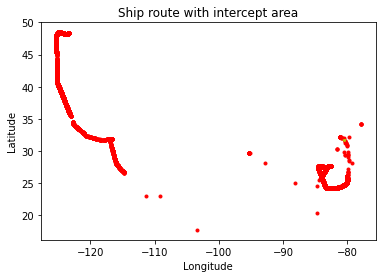

route of mmsi '636018146' intersects marine_conservation_area 'Georgia'


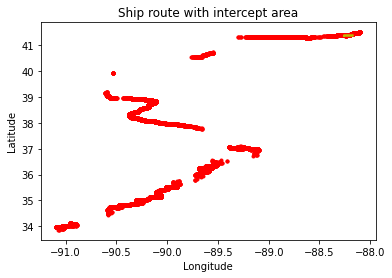

route of mmsi '366806920' intersects marine_conservation_area 'Demo'


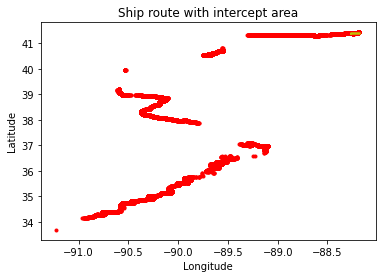

route of mmsi '367456890' intersects marine_conservation_area 'Demo'


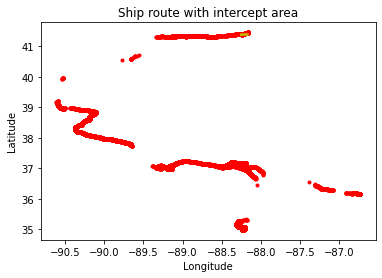

route of mmsi '367615770' intersects marine_conservation_area 'Demo'


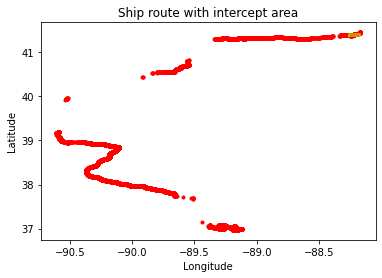

route of mmsi '367143920' intersects marine_conservation_area 'Demo'


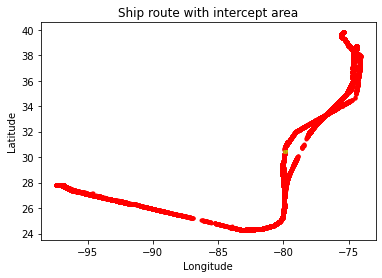

route of mmsi '367342960' intersects marine_conservation_area 'North Florida'


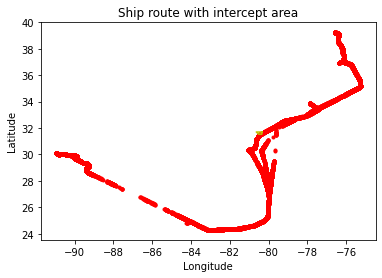

route of mmsi '369113000' intersects marine_conservation_area 'Georgia'


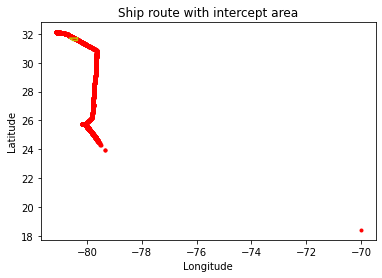

route of mmsi '255806122' intersects marine_conservation_area 'Georgia'


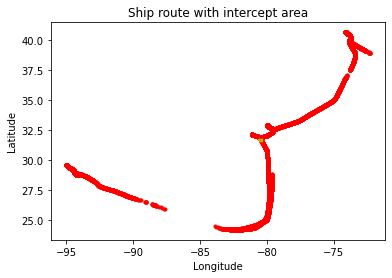

route of mmsi '338408000' intersects marine_conservation_area 'Georgia'


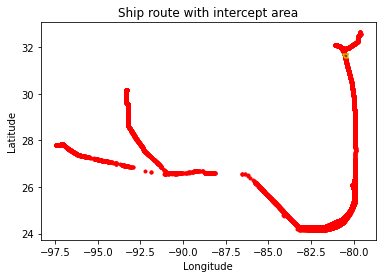

route of mmsi '368004000' intersects marine_conservation_area 'Georgia'


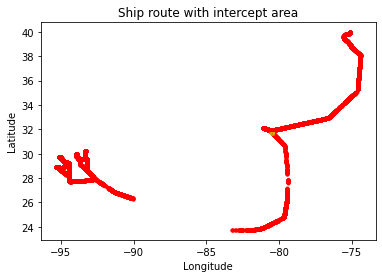

route of mmsi '636019200' intersects marine_conservation_area 'Georgia'


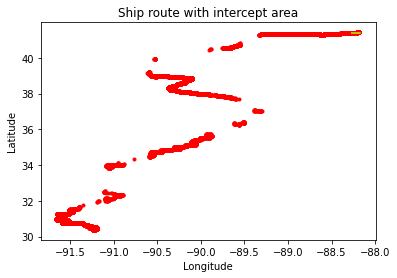

route of mmsi '366996690' intersects marine_conservation_area 'Demo'


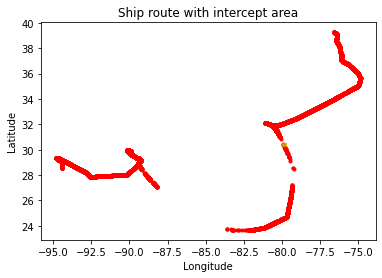

route of mmsi '477244300' intersects marine_conservation_area 'North Florida'


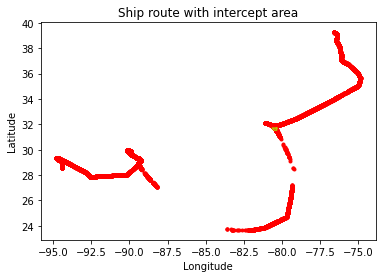

route of mmsi '477244300' intersects marine_conservation_area 'Georgia'


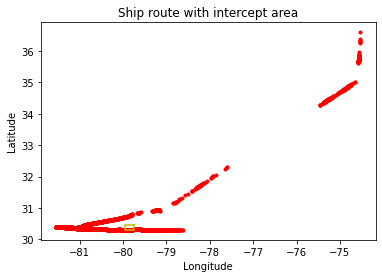

route of mmsi '309601000' intersects marine_conservation_area 'North Florida'


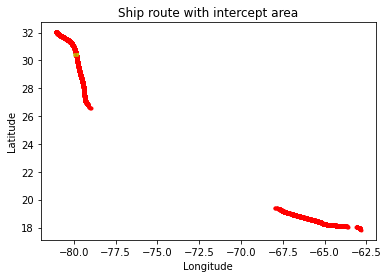

route of mmsi '319196400' intersects marine_conservation_area 'North Florida'


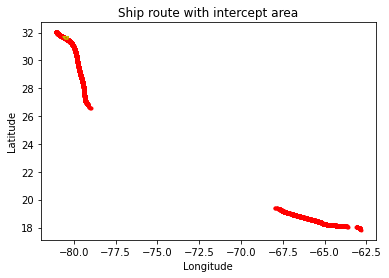

route of mmsi '319196400' intersects marine_conservation_area 'Georgia'


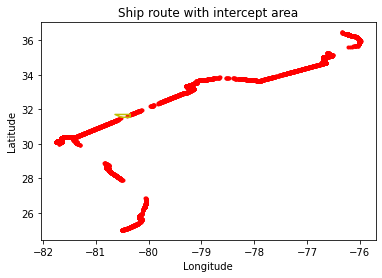

route of mmsi '338337624' intersects marine_conservation_area 'Georgia'


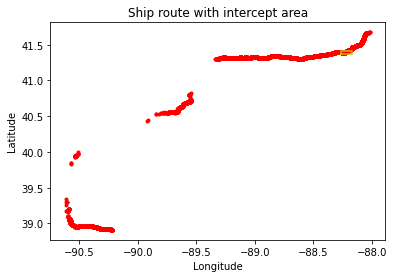

route of mmsi '368106340' intersects marine_conservation_area 'Demo'


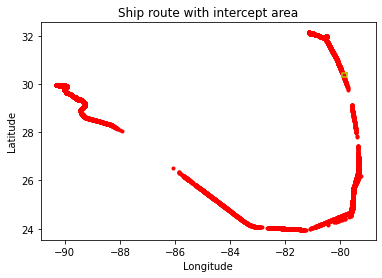

route of mmsi '538009498' intersects marine_conservation_area 'North Florida'


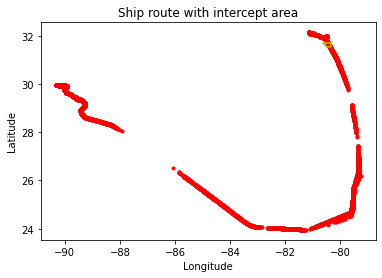

route of mmsi '538009498' intersects marine_conservation_area 'Georgia'


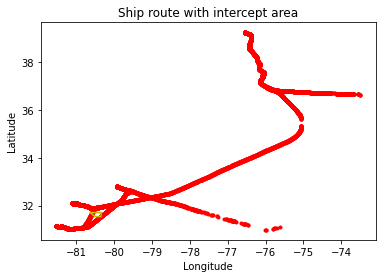

route of mmsi '308599000' intersects marine_conservation_area 'Georgia'


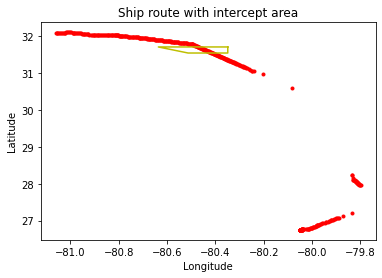

route of mmsi '319327000' intersects marine_conservation_area 'Georgia'


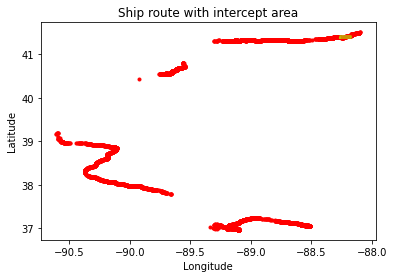

route of mmsi '367143710' intersects marine_conservation_area 'Demo'


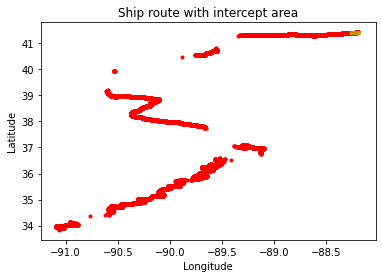

route of mmsi '367350460' intersects marine_conservation_area 'Demo'


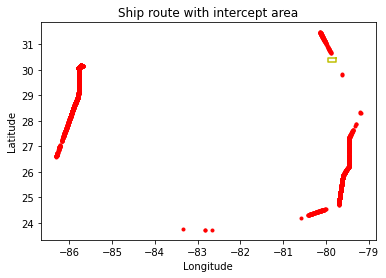

route of mmsi '235073372' intersects marine_conservation_area 'North Florida'


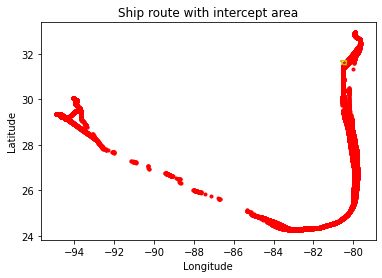

route of mmsi '367336000' intersects marine_conservation_area 'Georgia'


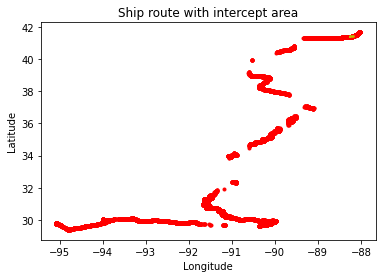

route of mmsi '368110550' intersects marine_conservation_area 'Demo'


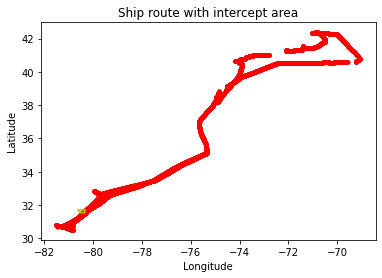

route of mmsi '366902260' intersects marine_conservation_area 'Georgia'


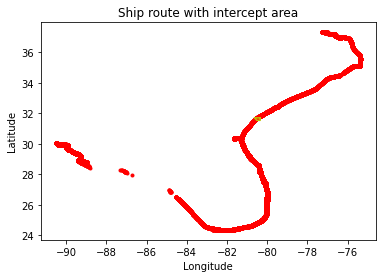

route of mmsi '368181750' intersects marine_conservation_area 'Georgia'


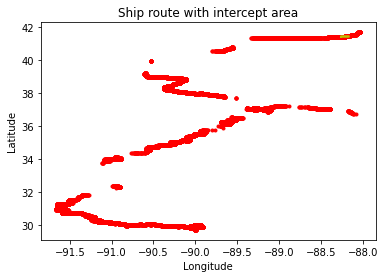

route of mmsi '367456880' intersects marine_conservation_area 'Demo'


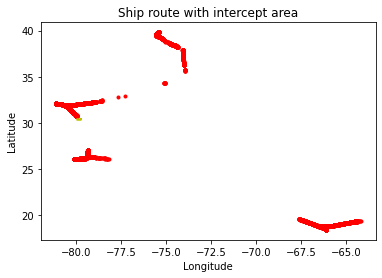

route of mmsi '538004410' intersects marine_conservation_area 'North Florida'


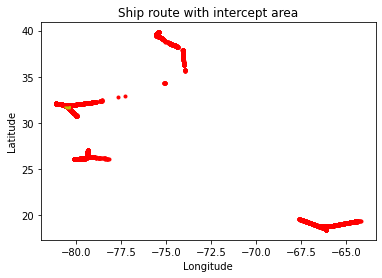

route of mmsi '538004410' intersects marine_conservation_area 'Georgia'


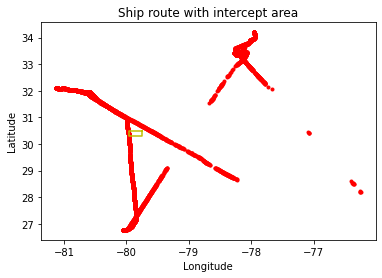

route of mmsi '244848000' intersects marine_conservation_area 'North Florida'


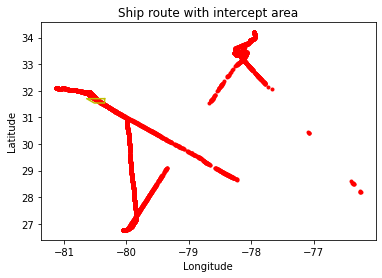

route of mmsi '244848000' intersects marine_conservation_area 'Georgia'


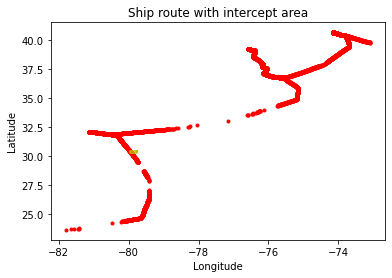

route of mmsi '248264000' intersects marine_conservation_area 'North Florida'


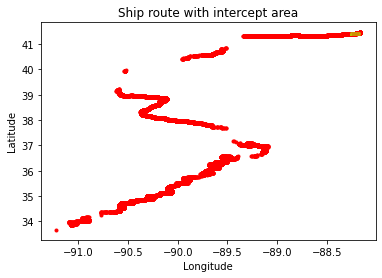

route of mmsi '367709190' intersects marine_conservation_area 'Demo'


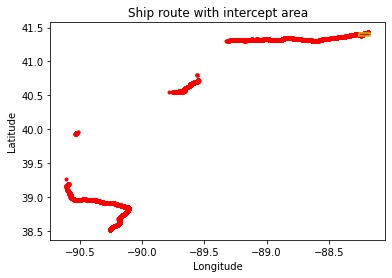

route of mmsi '366963050' intersects marine_conservation_area 'Demo'


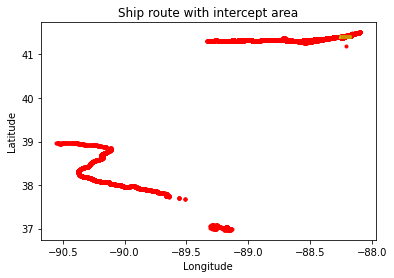

route of mmsi '367702080' intersects marine_conservation_area 'Demo'


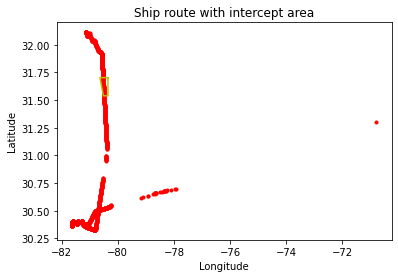

route of mmsi '636019035' intersects marine_conservation_area 'Georgia'


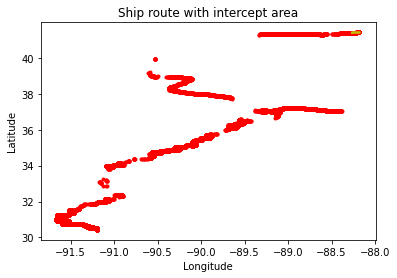

route of mmsi '367456980' intersects marine_conservation_area 'Demo'


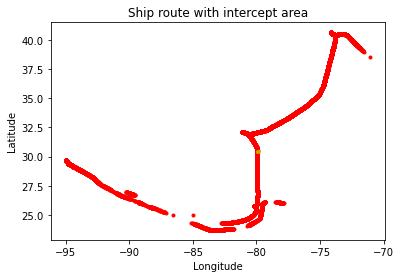

route of mmsi '538009375' intersects marine_conservation_area 'North Florida'


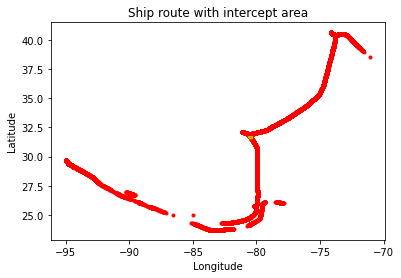

route of mmsi '538009375' intersects marine_conservation_area 'Georgia'


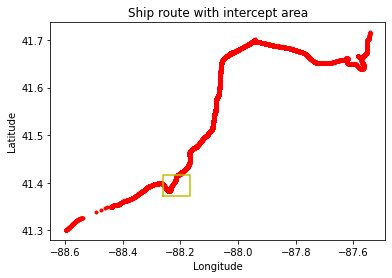

route of mmsi '368032620' intersects marine_conservation_area 'Demo'


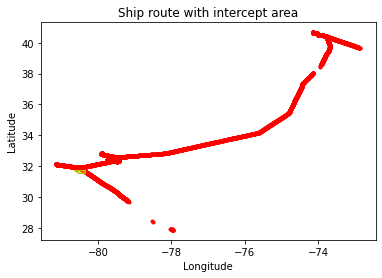

route of mmsi '566409000' intersects marine_conservation_area 'Georgia'


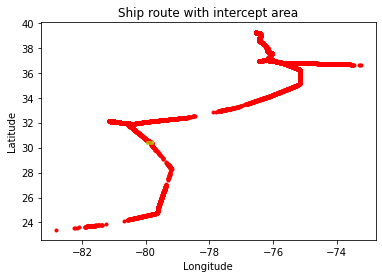

route of mmsi '249904000' intersects marine_conservation_area 'North Florida'


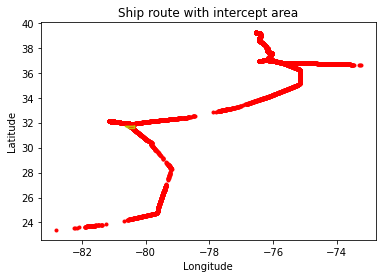

route of mmsi '249904000' intersects marine_conservation_area 'Georgia'


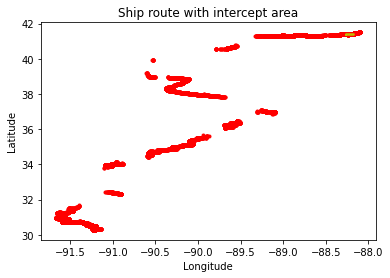

route of mmsi '367587420' intersects marine_conservation_area 'Demo'


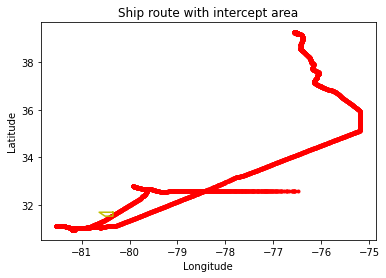

route of mmsi '538006326' intersects marine_conservation_area 'Georgia'


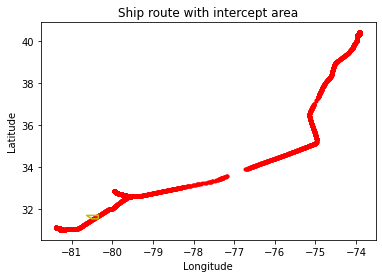

route of mmsi '367493000' intersects marine_conservation_area 'Georgia'


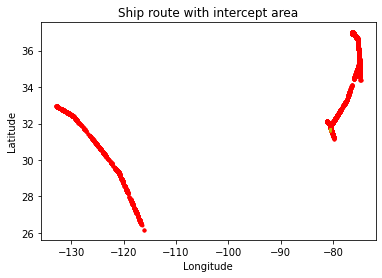

route of mmsi '636014169' intersects marine_conservation_area 'Georgia'


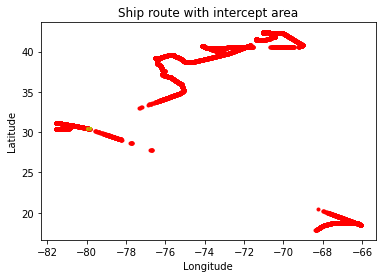

route of mmsi '308369000' intersects marine_conservation_area 'North Florida'


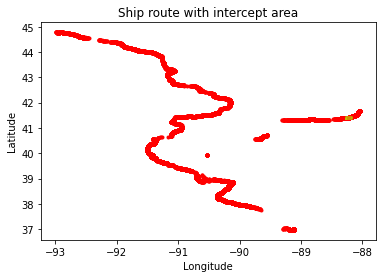

route of mmsi '367580880' intersects marine_conservation_area 'Demo'


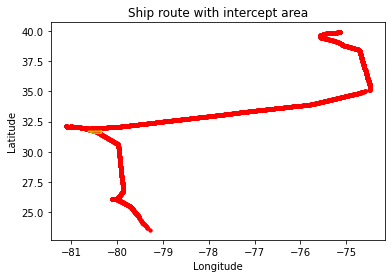

route of mmsi '636017929' intersects marine_conservation_area 'Georgia'


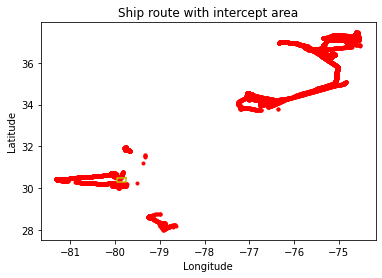

route of mmsi '303882000' intersects marine_conservation_area 'North Florida'


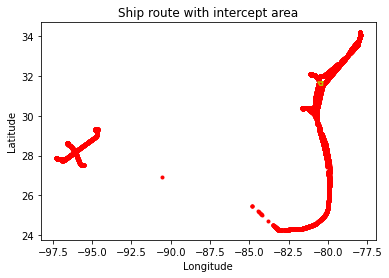

route of mmsi '366843420' intersects marine_conservation_area 'Georgia'


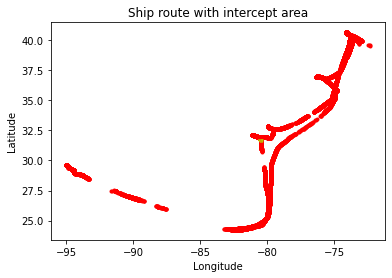

route of mmsi '369309000' intersects marine_conservation_area 'Georgia'


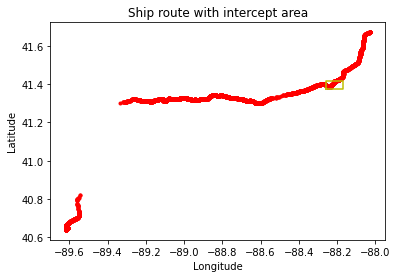

route of mmsi '367122230' intersects marine_conservation_area 'Demo'


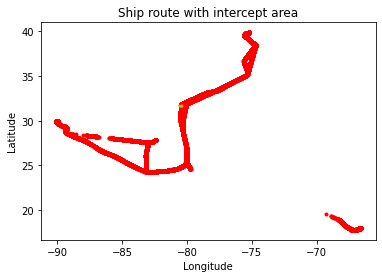

route of mmsi '367336380' intersects marine_conservation_area 'Georgia'


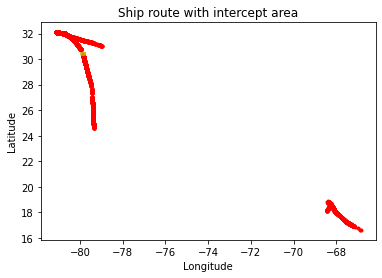

route of mmsi '257432000' intersects marine_conservation_area 'North Florida'


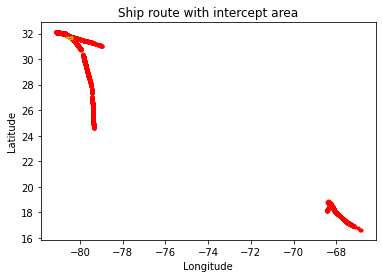

route of mmsi '257432000' intersects marine_conservation_area 'Georgia'


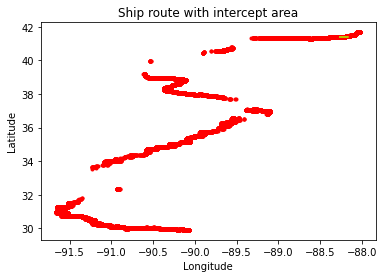

route of mmsi '367791530' intersects marine_conservation_area 'Demo'


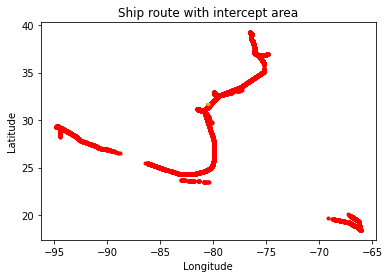

route of mmsi '303210000' intersects marine_conservation_area 'Georgia'


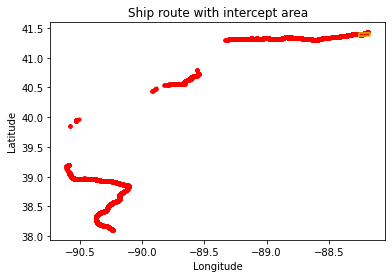

route of mmsi '366967590' intersects marine_conservation_area 'Demo'


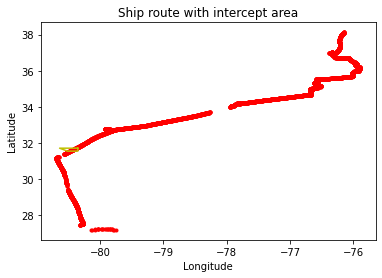

route of mmsi '368048790' intersects marine_conservation_area 'Georgia'


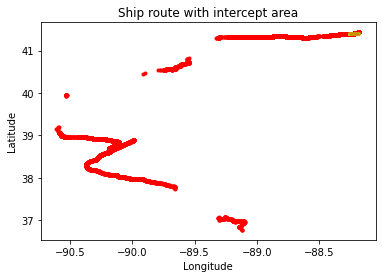

route of mmsi '366967450' intersects marine_conservation_area 'Demo'


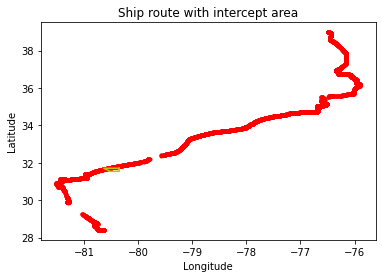

route of mmsi '367455260' intersects marine_conservation_area 'Georgia'


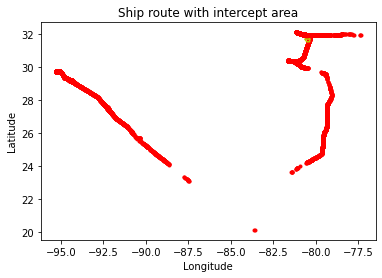

route of mmsi '538008705' intersects marine_conservation_area 'Georgia'


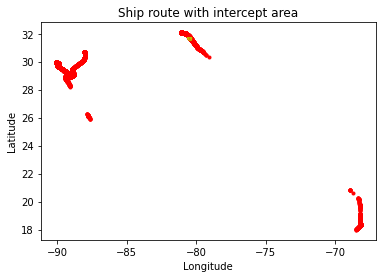

route of mmsi '257435000' intersects marine_conservation_area 'Georgia'


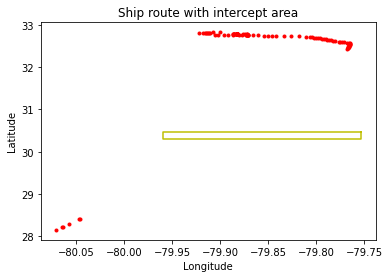

route of mmsi '338431463' intersects marine_conservation_area 'North Florida'


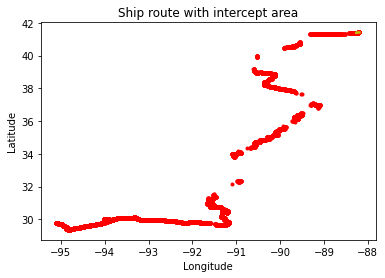

route of mmsi '367496980' intersects marine_conservation_area 'Demo'


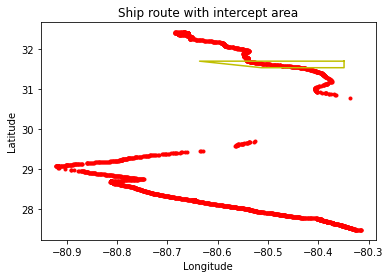

route of mmsi '269576000' intersects marine_conservation_area 'Georgia'


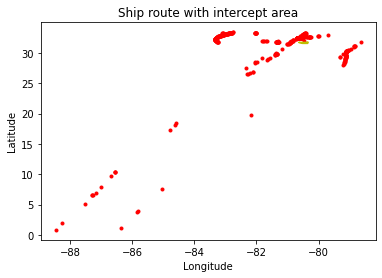

route of mmsi '338252832' intersects marine_conservation_area 'Georgia'


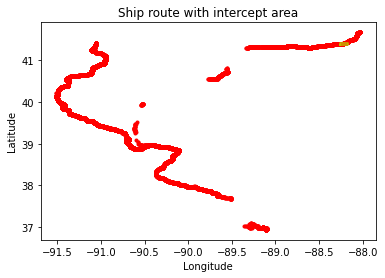

route of mmsi '367638150' intersects marine_conservation_area 'Demo'


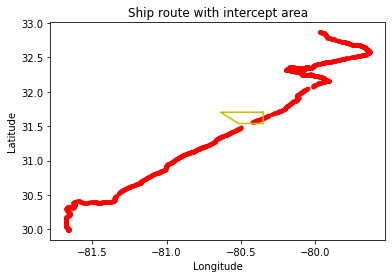

route of mmsi '367168770' intersects marine_conservation_area 'Georgia'


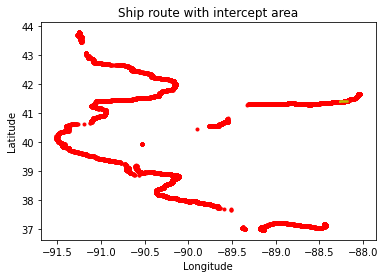

route of mmsi '368167250' intersects marine_conservation_area 'Demo'


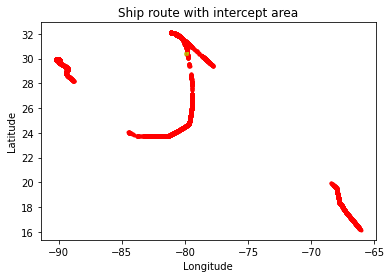

route of mmsi '636020823' intersects marine_conservation_area 'North Florida'


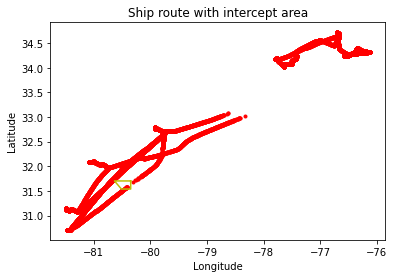

route of mmsi '367073540' intersects marine_conservation_area 'Georgia'


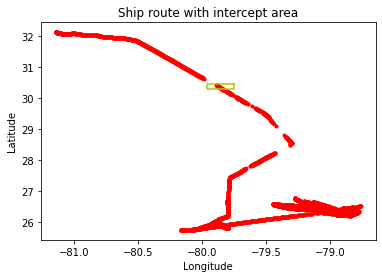

route of mmsi '563001700' intersects marine_conservation_area 'North Florida'


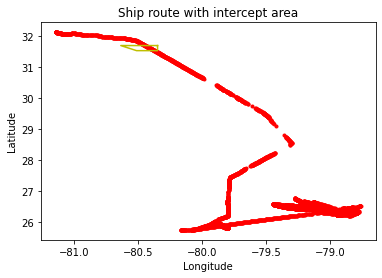

route of mmsi '563001700' intersects marine_conservation_area 'Georgia'


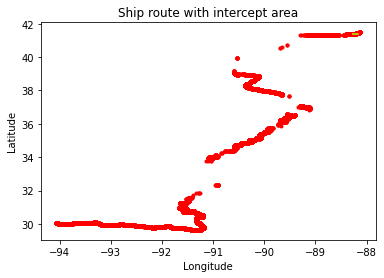

route of mmsi '367541160' intersects marine_conservation_area 'Demo'


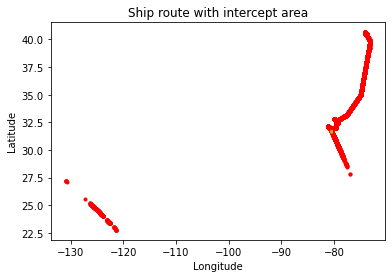

route of mmsi '563126500' intersects marine_conservation_area 'Georgia'


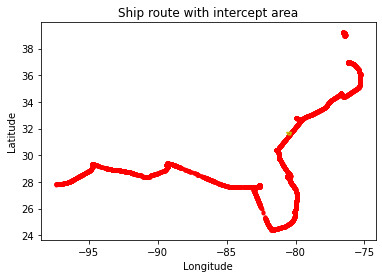

route of mmsi '366999628' intersects marine_conservation_area 'Georgia'


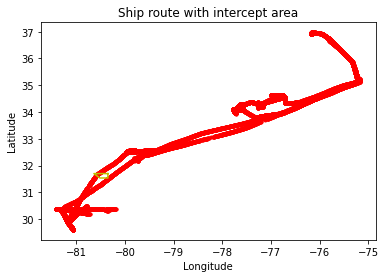

route of mmsi '367841000' intersects marine_conservation_area 'Georgia'


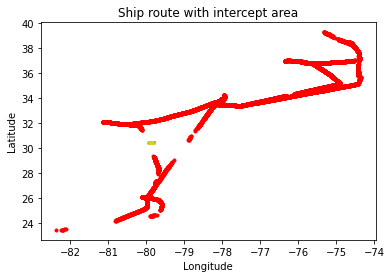

route of mmsi '218826000' intersects marine_conservation_area 'North Florida'


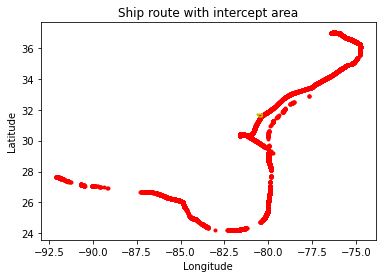

route of mmsi '369599000' intersects marine_conservation_area 'Georgia'


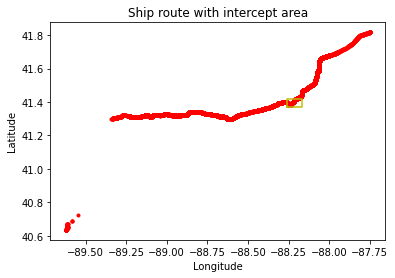

route of mmsi '367396110' intersects marine_conservation_area 'Demo'


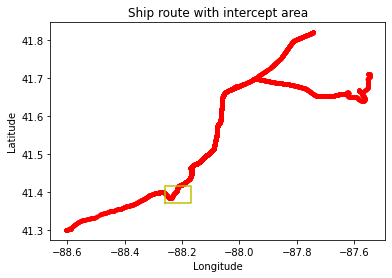

route of mmsi '368009880' intersects marine_conservation_area 'Demo'


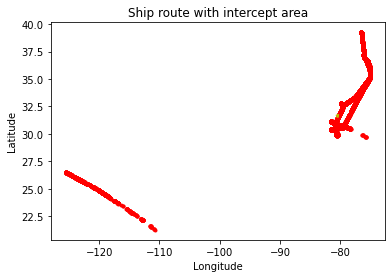

route of mmsi '319058000' intersects marine_conservation_area 'Georgia'


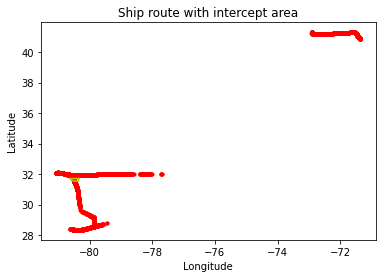

route of mmsi '538005243' intersects marine_conservation_area 'Georgia'


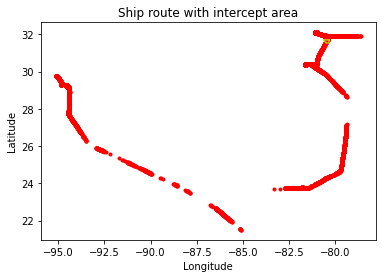

route of mmsi '636019994' intersects marine_conservation_area 'Georgia'


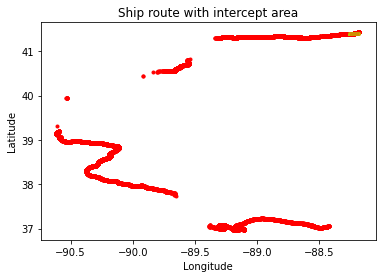

route of mmsi '367456680' intersects marine_conservation_area 'Demo'


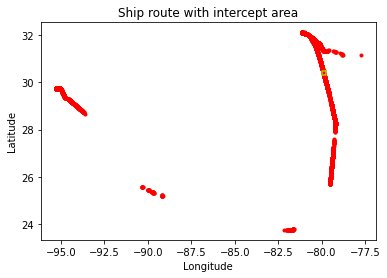

route of mmsi '548922000' intersects marine_conservation_area 'North Florida'


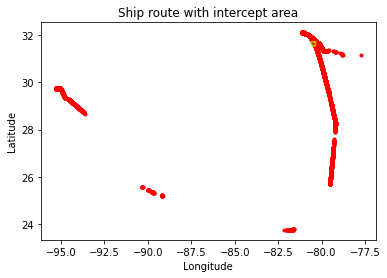

route of mmsi '548922000' intersects marine_conservation_area 'Georgia'


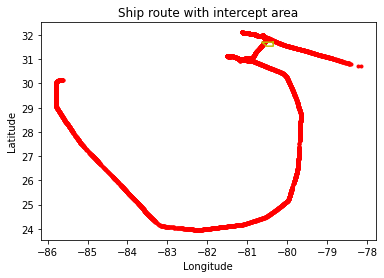

route of mmsi '257424000' intersects marine_conservation_area 'Georgia'


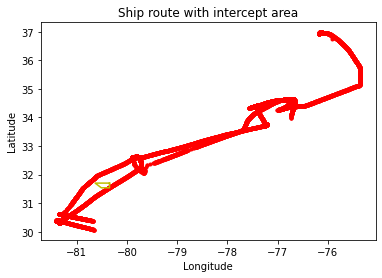

route of mmsi '369857000' intersects marine_conservation_area 'Georgia'


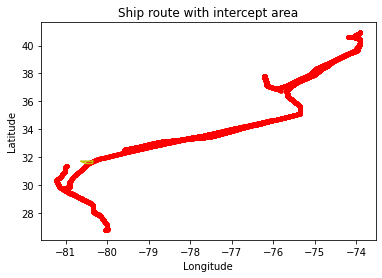

route of mmsi '367656790' intersects marine_conservation_area 'Georgia'


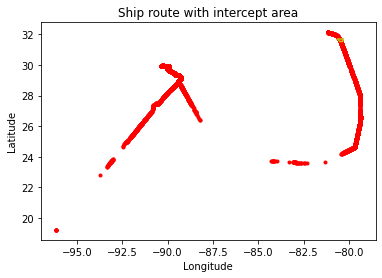

route of mmsi '355920000' intersects marine_conservation_area 'Georgia'


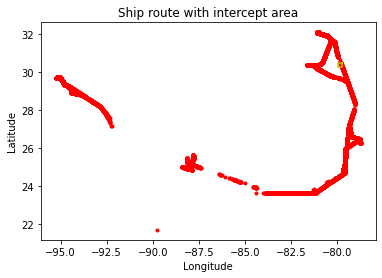

route of mmsi '538008154' intersects marine_conservation_area 'North Florida'


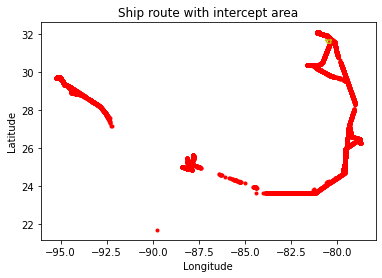

route of mmsi '538008154' intersects marine_conservation_area 'Georgia'


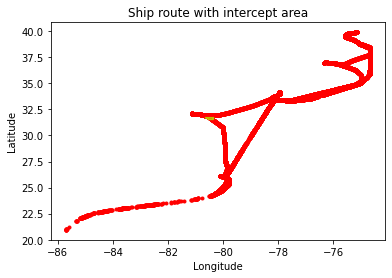

route of mmsi '477754600' intersects marine_conservation_area 'Georgia'


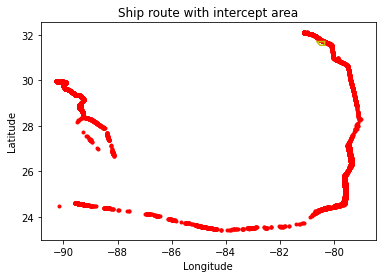

route of mmsi '566914000' intersects marine_conservation_area 'Georgia'


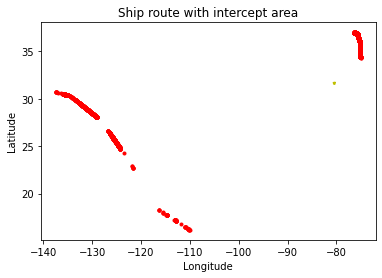

route of mmsi '636019197' intersects marine_conservation_area 'Georgia'


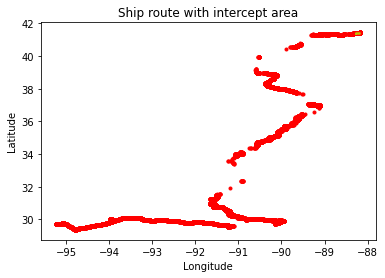

route of mmsi '367428150' intersects marine_conservation_area 'Demo'


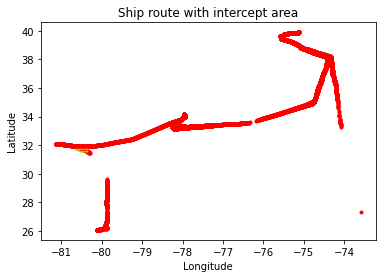

route of mmsi '477197100' intersects marine_conservation_area 'Georgia'


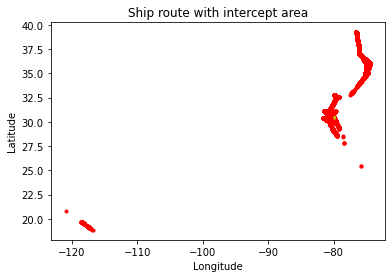

route of mmsi '353332000' intersects marine_conservation_area 'North Florida'


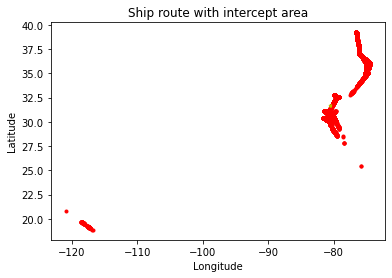

route of mmsi '353332000' intersects marine_conservation_area 'Georgia'


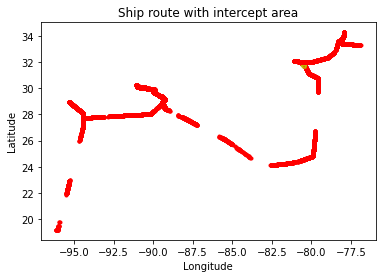

route of mmsi '538008349' intersects marine_conservation_area 'Georgia'


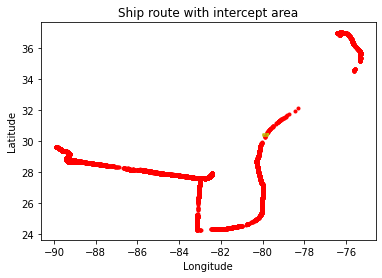

route of mmsi '338724000' intersects marine_conservation_area 'North Florida'


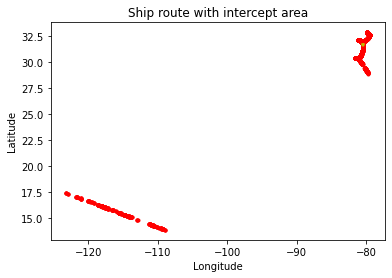

route of mmsi '636014220' intersects marine_conservation_area 'Georgia'


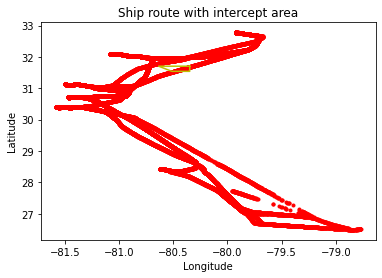

route of mmsi '311050400' intersects marine_conservation_area 'Georgia'


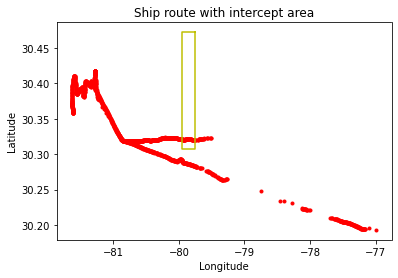

route of mmsi '538007822' intersects marine_conservation_area 'North Florida'


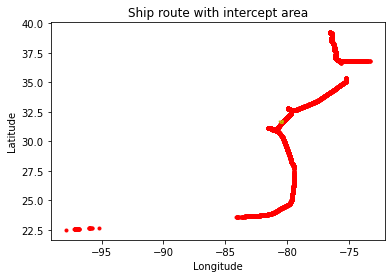

route of mmsi '338058000' intersects marine_conservation_area 'Georgia'


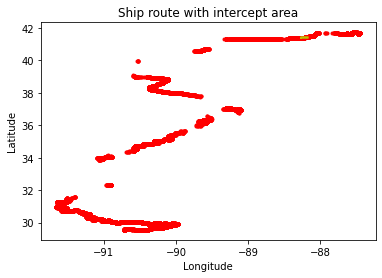

route of mmsi '368113360' intersects marine_conservation_area 'Demo'


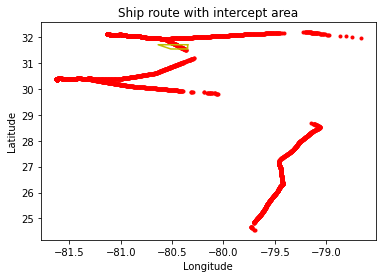

route of mmsi '271049229' intersects marine_conservation_area 'Georgia'


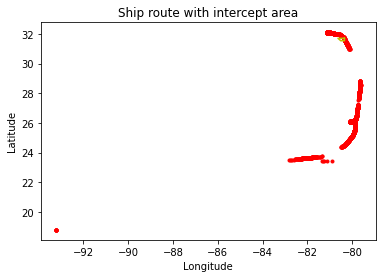

route of mmsi '304080796' intersects marine_conservation_area 'Georgia'


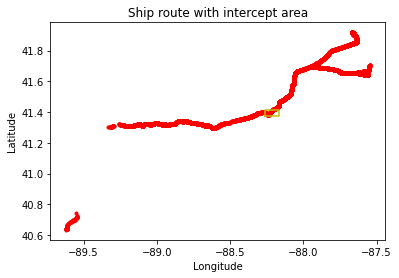

route of mmsi '367635370' intersects marine_conservation_area 'Demo'


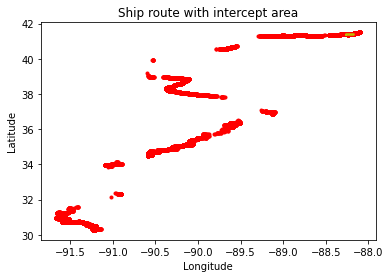

route of mmsi '367604920' intersects marine_conservation_area 'Demo'


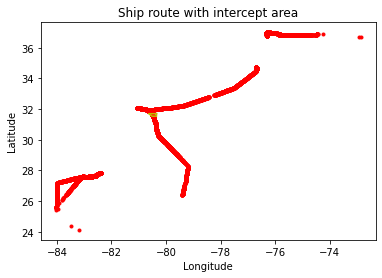

route of mmsi '563001900' intersects marine_conservation_area 'Georgia'


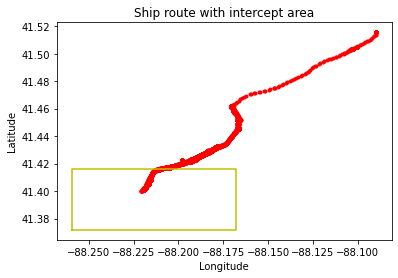

route of mmsi '367556250' intersects marine_conservation_area 'Demo'


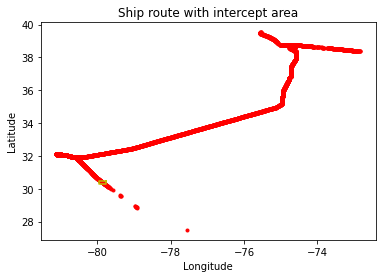

route of mmsi '563549000' intersects marine_conservation_area 'North Florida'


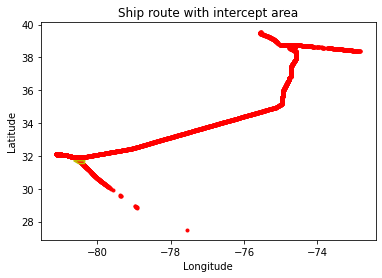

route of mmsi '563549000' intersects marine_conservation_area 'Georgia'


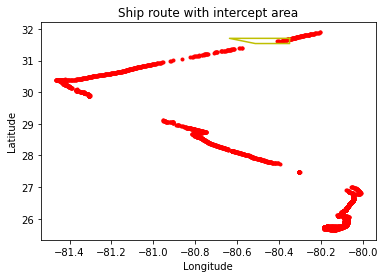

route of mmsi '338349109' intersects marine_conservation_area 'Georgia'


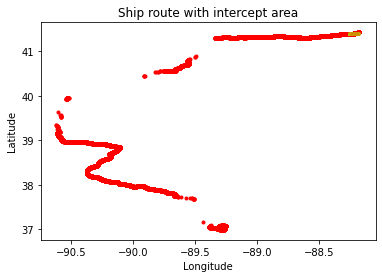

route of mmsi '367456850' intersects marine_conservation_area 'Demo'


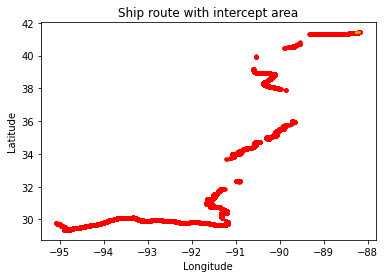

route of mmsi '367762880' intersects marine_conservation_area 'Demo'


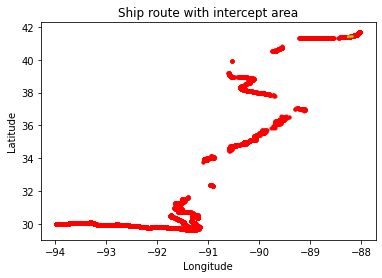

route of mmsi '367628230' intersects marine_conservation_area 'Demo'


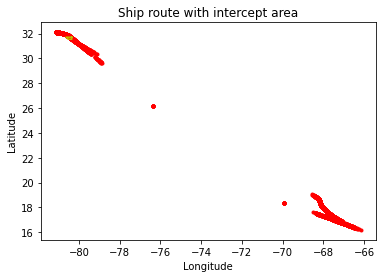

route of mmsi '257482000' intersects marine_conservation_area 'Georgia'


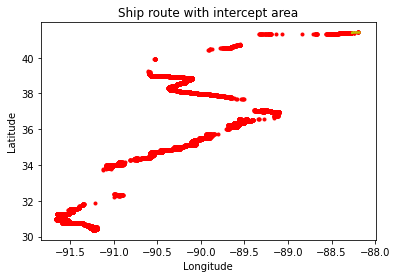

route of mmsi '367506940' intersects marine_conservation_area 'Demo'


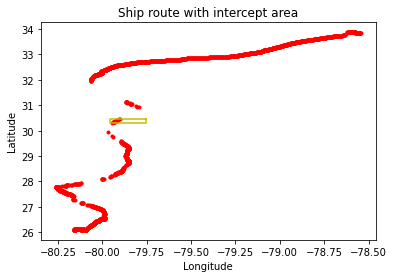

route of mmsi '367688990' intersects marine_conservation_area 'North Florida'


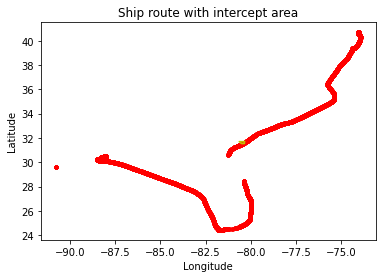

route of mmsi '368234460' intersects marine_conservation_area 'Georgia'


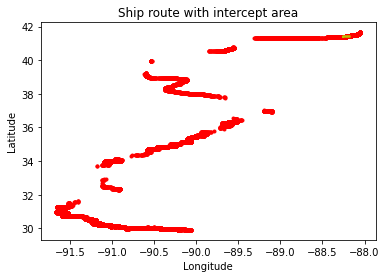

route of mmsi '367675910' intersects marine_conservation_area 'Demo'


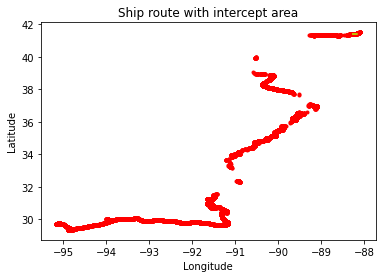

route of mmsi '367471910' intersects marine_conservation_area 'Demo'


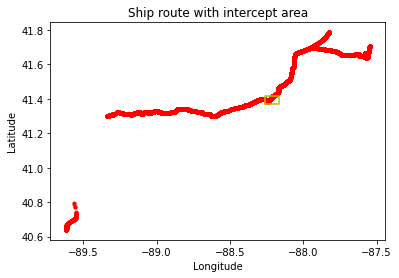

route of mmsi '368017750' intersects marine_conservation_area 'Demo'


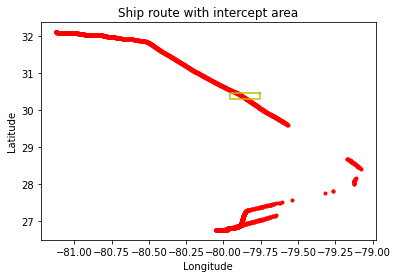

route of mmsi '244117000' intersects marine_conservation_area 'North Florida'


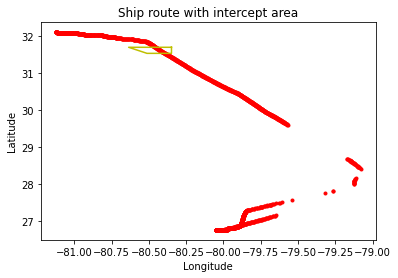

route of mmsi '244117000' intersects marine_conservation_area 'Georgia'


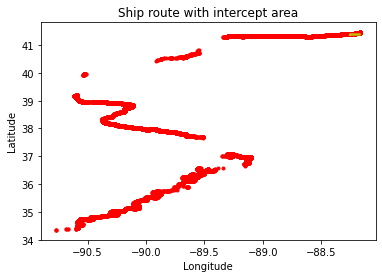

route of mmsi '366799770' intersects marine_conservation_area 'Demo'


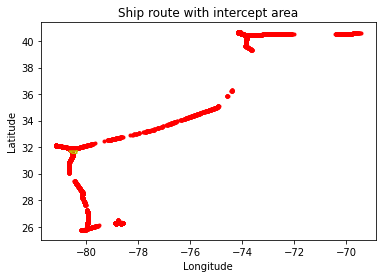

route of mmsi '563000800' intersects marine_conservation_area 'Georgia'


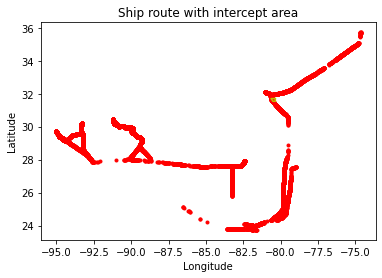

route of mmsi '636019179' intersects marine_conservation_area 'Georgia'


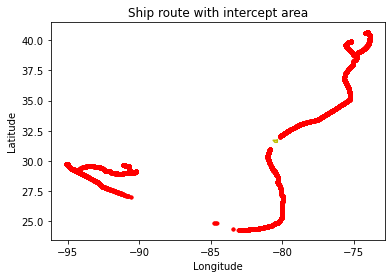

route of mmsi '338495000' intersects marine_conservation_area 'Georgia'


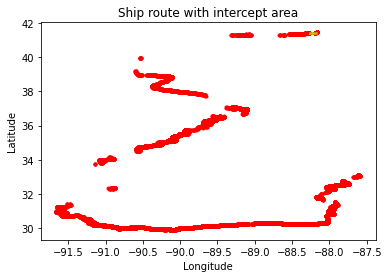

route of mmsi '367544060' intersects marine_conservation_area 'Demo'


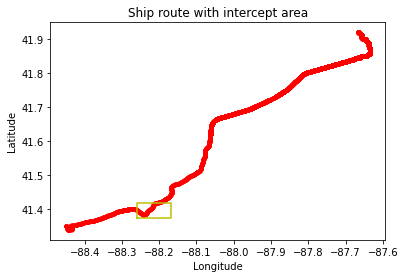

route of mmsi '367709820' intersects marine_conservation_area 'Demo'


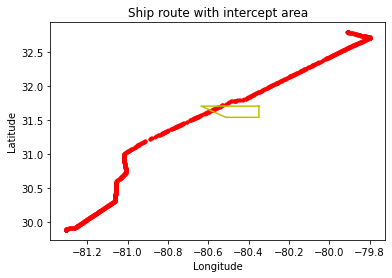

route of mmsi '367512730' intersects marine_conservation_area 'Georgia'


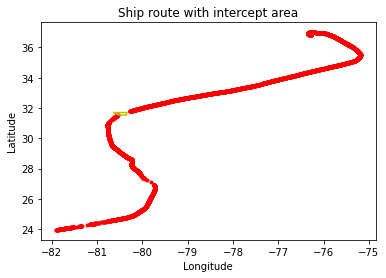

route of mmsi '368235760' intersects marine_conservation_area 'Georgia'


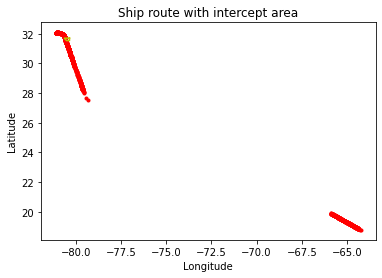

route of mmsi '319035600' intersects marine_conservation_area 'Georgia'


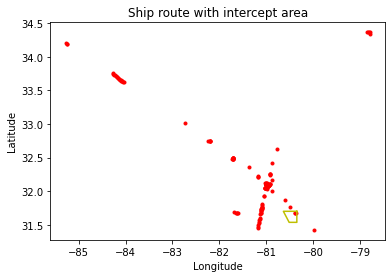

route of mmsi '338198348' intersects marine_conservation_area 'Georgia'


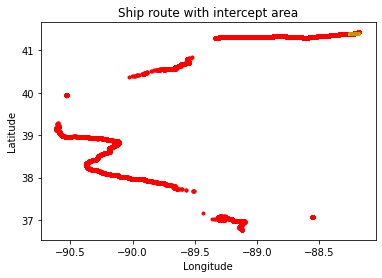

route of mmsi '366963010' intersects marine_conservation_area 'Demo'


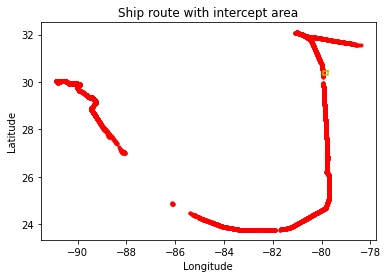

route of mmsi '355142000' intersects marine_conservation_area 'North Florida'


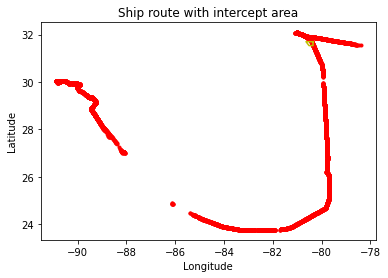

route of mmsi '355142000' intersects marine_conservation_area 'Georgia'


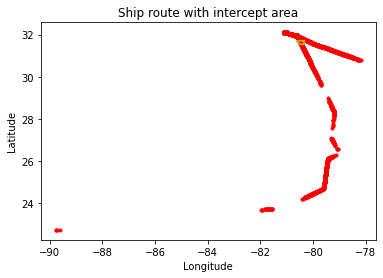

route of mmsi '538008362' intersects marine_conservation_area 'Georgia'


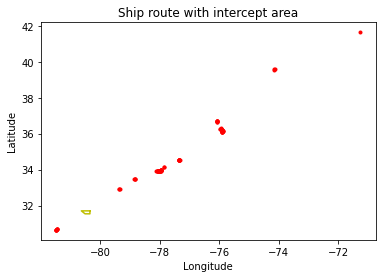

route of mmsi '338160644' intersects marine_conservation_area 'Georgia'


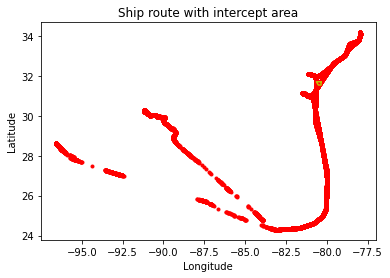

route of mmsi '368009000' intersects marine_conservation_area 'Georgia'


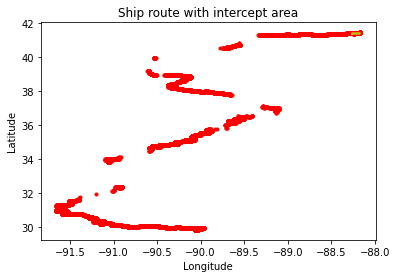

route of mmsi '366935390' intersects marine_conservation_area 'Demo'


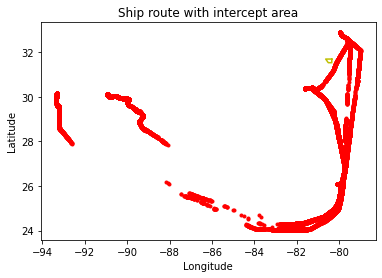

route of mmsi '366508000' intersects marine_conservation_area 'Georgia'


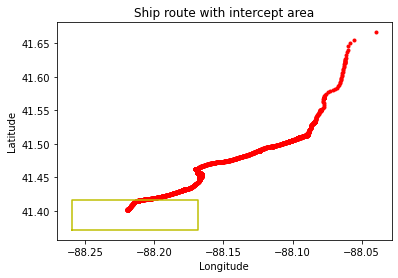

route of mmsi '368106730' intersects marine_conservation_area 'Demo'


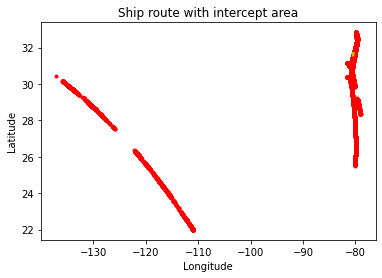

route of mmsi '368473000' intersects marine_conservation_area 'Georgia'


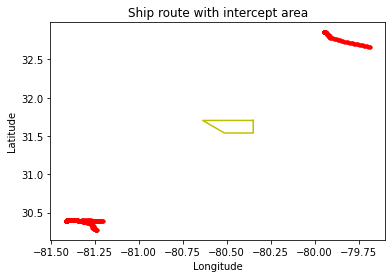

route of mmsi '368883000' intersects marine_conservation_area 'Georgia'


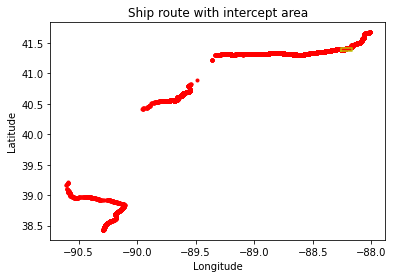

route of mmsi '367702130' intersects marine_conservation_area 'Demo'


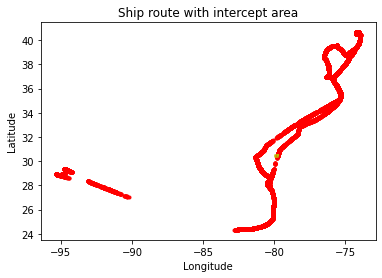

route of mmsi '367677130' intersects marine_conservation_area 'North Florida'


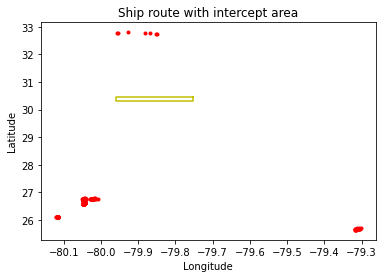

route of mmsi '319211000' intersects marine_conservation_area 'North Florida'


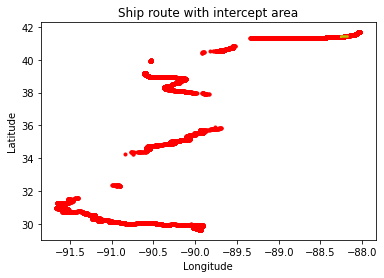

route of mmsi '367456940' intersects marine_conservation_area 'Demo'


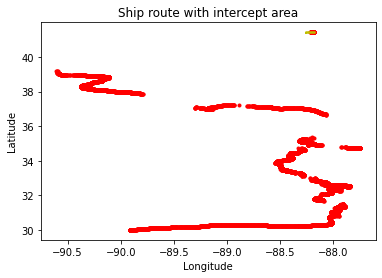

route of mmsi '367595460' intersects marine_conservation_area 'Demo'


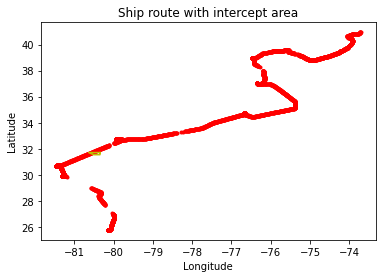

route of mmsi '368179240' intersects marine_conservation_area 'Georgia'


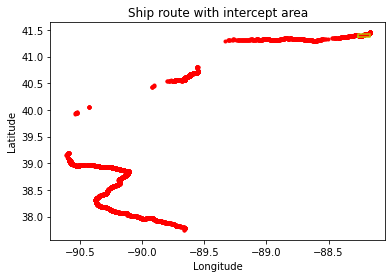

route of mmsi '368181680' intersects marine_conservation_area 'Demo'


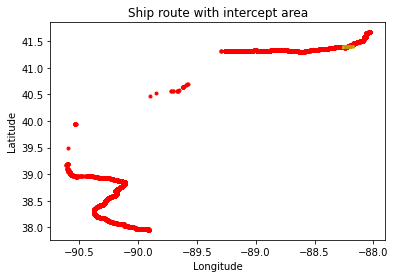

route of mmsi '367645470' intersects marine_conservation_area 'Demo'


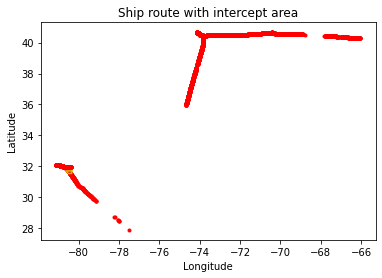

route of mmsi '563417000' intersects marine_conservation_area 'Georgia'


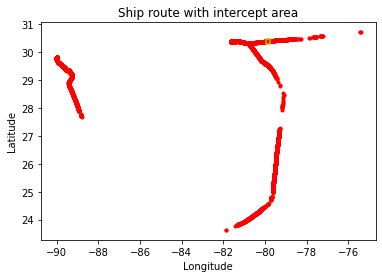

route of mmsi '477527900' intersects marine_conservation_area 'North Florida'


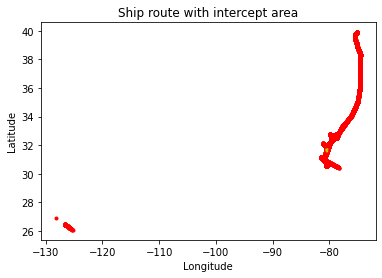

route of mmsi '636015771' intersects marine_conservation_area 'Georgia'


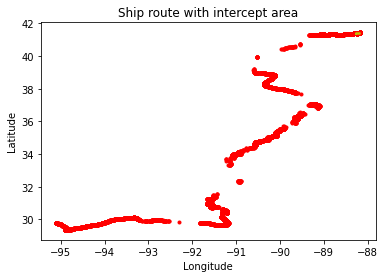

route of mmsi '367740050' intersects marine_conservation_area 'Demo'


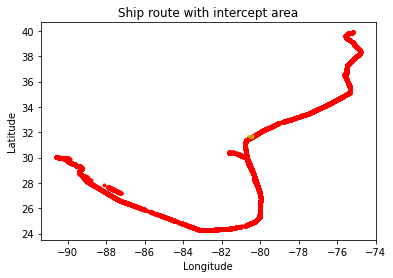

route of mmsi '367416750' intersects marine_conservation_area 'Georgia'


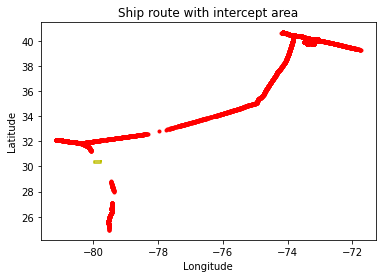

route of mmsi '255806500' intersects marine_conservation_area 'North Florida'


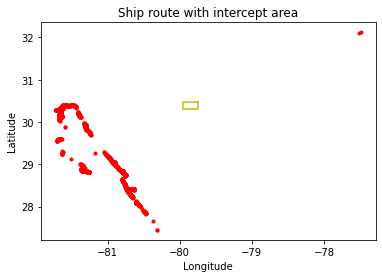

route of mmsi '338183093' intersects marine_conservation_area 'North Florida'


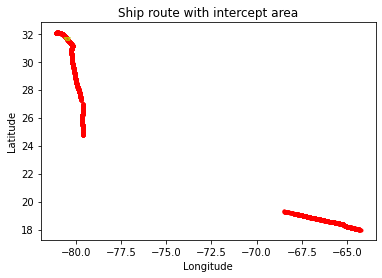

route of mmsi '235086316' intersects marine_conservation_area 'Georgia'


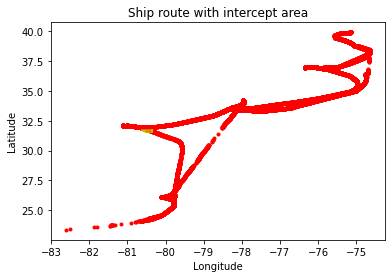

route of mmsi '636020192' intersects marine_conservation_area 'Georgia'


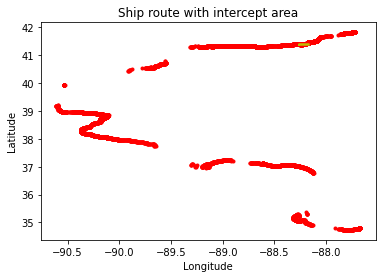

route of mmsi '367687870' intersects marine_conservation_area 'Demo'


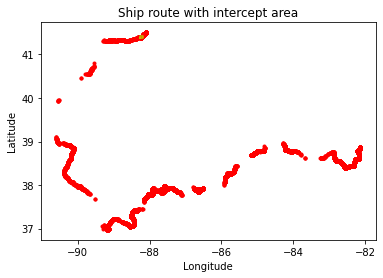

route of mmsi '368176610' intersects marine_conservation_area 'Demo'


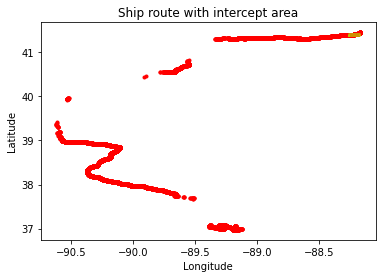

route of mmsi '367057940' intersects marine_conservation_area 'Demo'


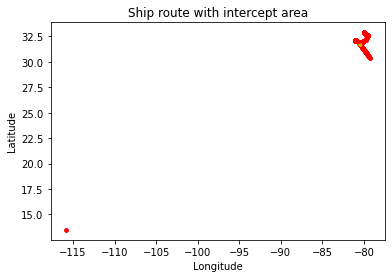

route of mmsi '477133700' intersects marine_conservation_area 'Georgia'


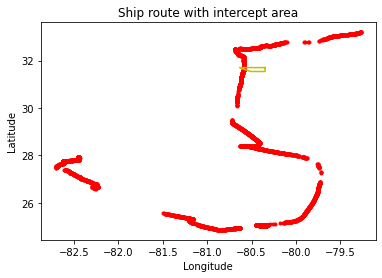

route of mmsi '338140868' intersects marine_conservation_area 'Georgia'


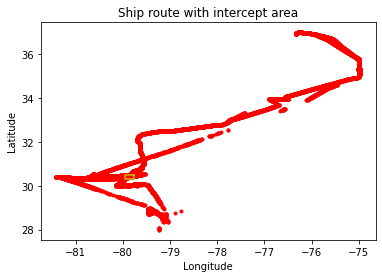

route of mmsi '367852000' intersects marine_conservation_area 'North Florida'


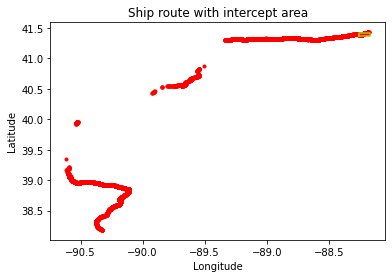

route of mmsi '366963060' intersects marine_conservation_area 'Demo'


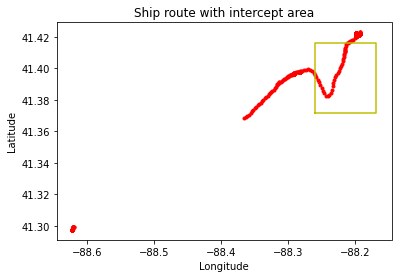

route of mmsi '367625510' intersects marine_conservation_area 'Demo'


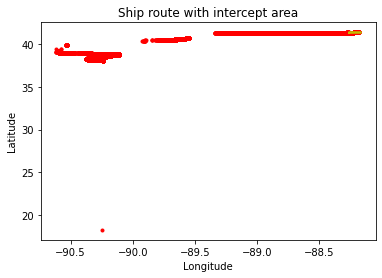

route of mmsi '366967580' intersects marine_conservation_area 'Demo'


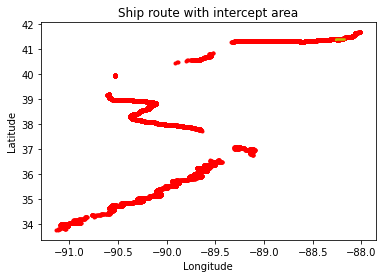

route of mmsi '368107910' intersects marine_conservation_area 'Demo'


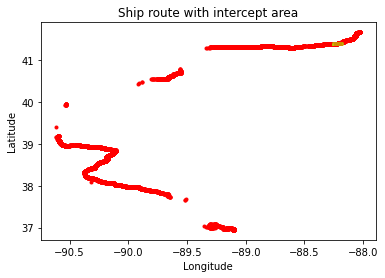

route of mmsi '367638170' intersects marine_conservation_area 'Demo'


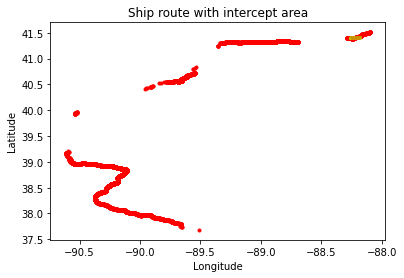

route of mmsi '366993550' intersects marine_conservation_area 'Demo'


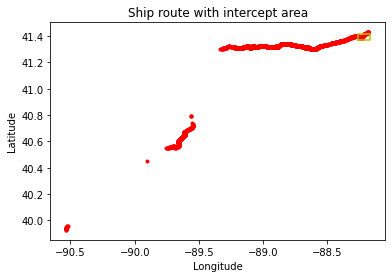

route of mmsi '366970780' intersects marine_conservation_area 'Demo'


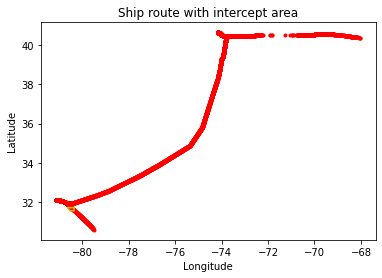

route of mmsi '636092713' intersects marine_conservation_area 'Georgia'


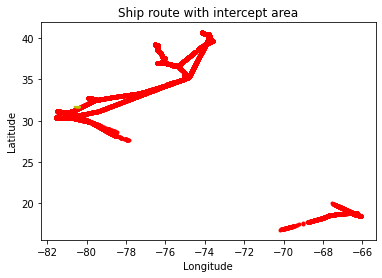

route of mmsi '431695000' intersects marine_conservation_area 'Georgia'


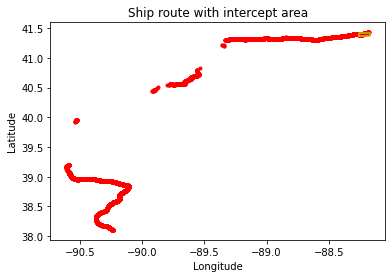

route of mmsi '366963470' intersects marine_conservation_area 'Demo'


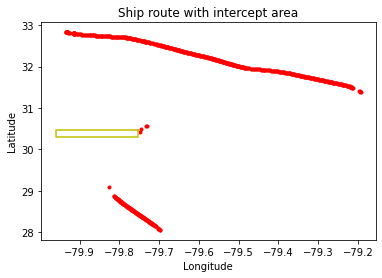

route of mmsi '367671590' intersects marine_conservation_area 'North Florida'


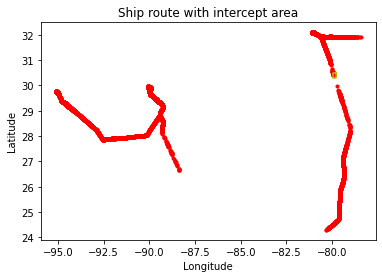

route of mmsi '538003291' intersects marine_conservation_area 'North Florida'


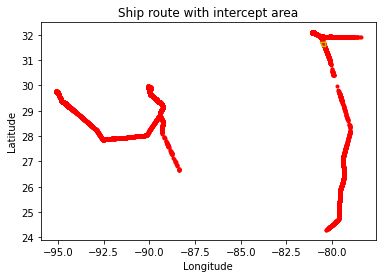

route of mmsi '538003291' intersects marine_conservation_area 'Georgia'


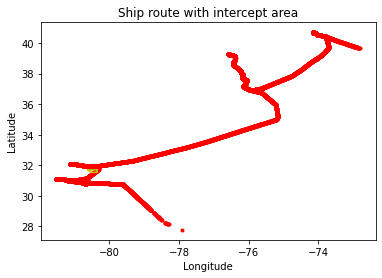

route of mmsi '266261000' intersects marine_conservation_area 'Georgia'


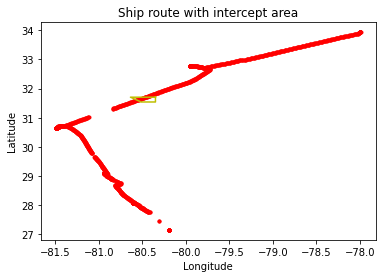

route of mmsi '338402992' intersects marine_conservation_area 'Georgia'


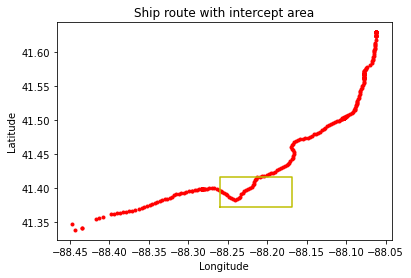

route of mmsi '367709840' intersects marine_conservation_area 'Demo'


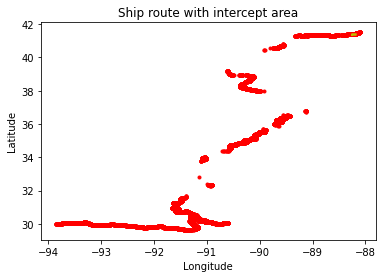

route of mmsi '368170010' intersects marine_conservation_area 'Demo'


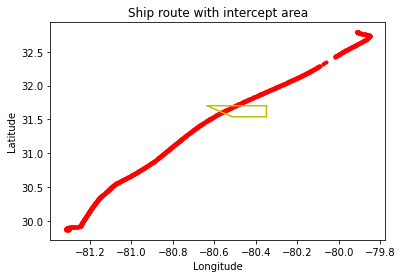

route of mmsi '367775410' intersects marine_conservation_area 'Georgia'


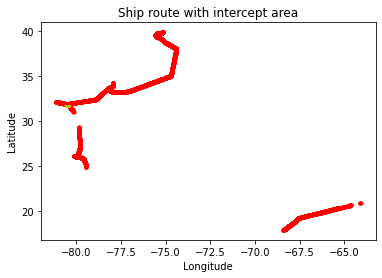

route of mmsi '563066900' intersects marine_conservation_area 'Georgia'


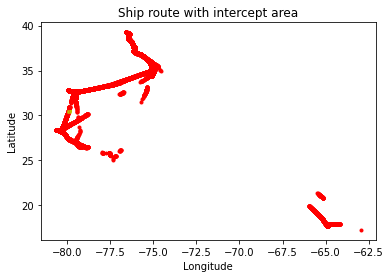

route of mmsi '311733000' intersects marine_conservation_area 'North Florida'


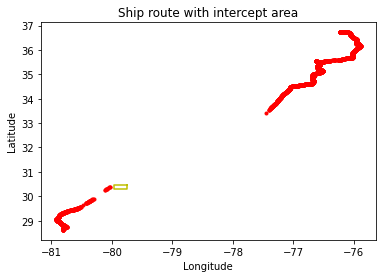

route of mmsi '367721430' intersects marine_conservation_area 'North Florida'


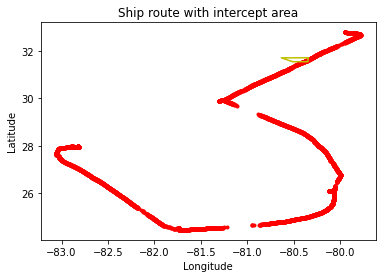

route of mmsi '368082370' intersects marine_conservation_area 'Georgia'


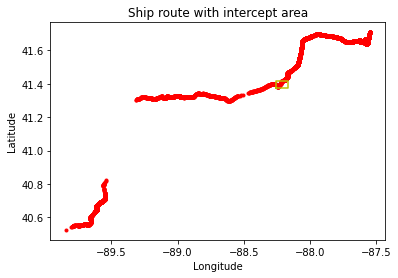

route of mmsi '367005170' intersects marine_conservation_area 'Demo'


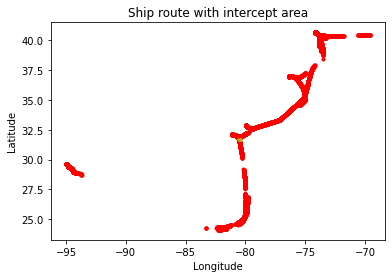

route of mmsi '338474000' intersects marine_conservation_area 'Georgia'


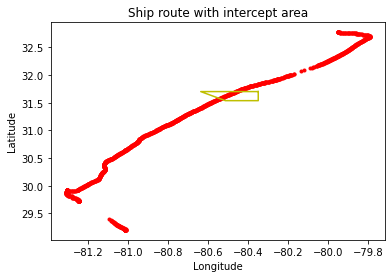

route of mmsi '368126530' intersects marine_conservation_area 'Georgia'


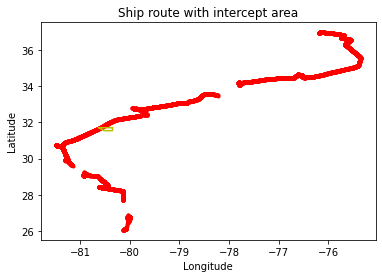

route of mmsi '378113413' intersects marine_conservation_area 'Georgia'


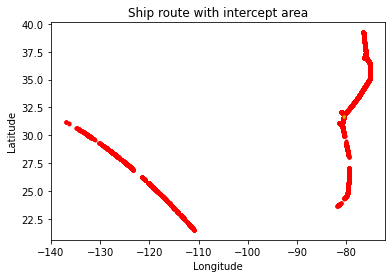

route of mmsi '441120000' intersects marine_conservation_area 'Georgia'


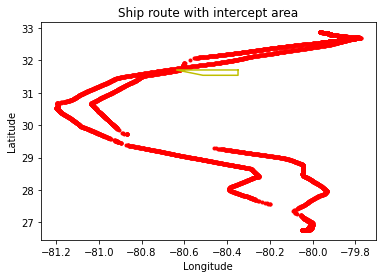

route of mmsi '303327000' intersects marine_conservation_area 'Georgia'


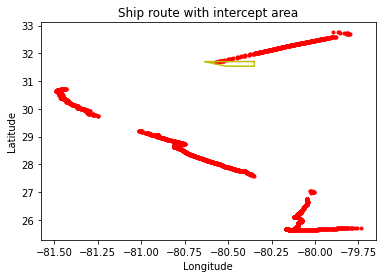

route of mmsi '368071160' intersects marine_conservation_area 'Georgia'


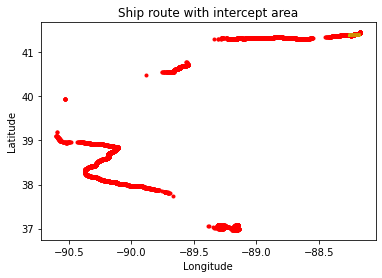

route of mmsi '368083040' intersects marine_conservation_area 'Demo'


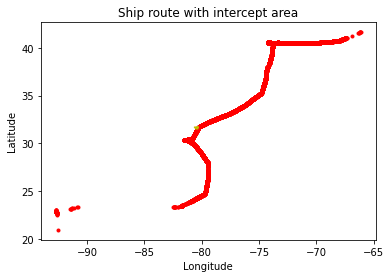

route of mmsi '563074600' intersects marine_conservation_area 'Georgia'


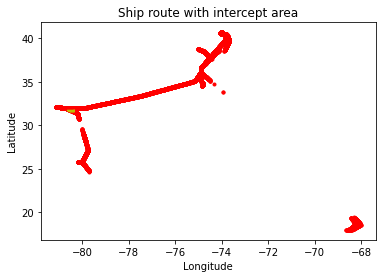

route of mmsi '210159000' intersects marine_conservation_area 'Georgia'


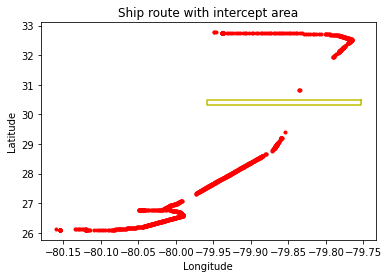

route of mmsi '367732180' intersects marine_conservation_area 'North Florida'


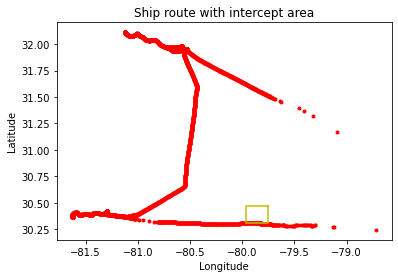

route of mmsi '636019823' intersects marine_conservation_area 'North Florida'


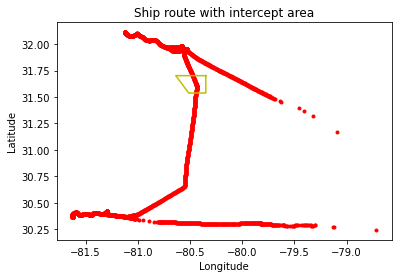

route of mmsi '636019823' intersects marine_conservation_area 'Georgia'


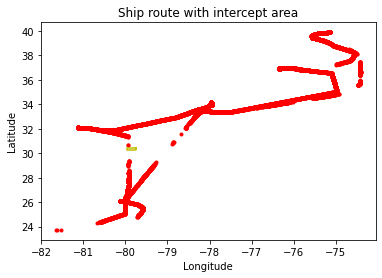

route of mmsi '229821000' intersects marine_conservation_area 'North Florida'


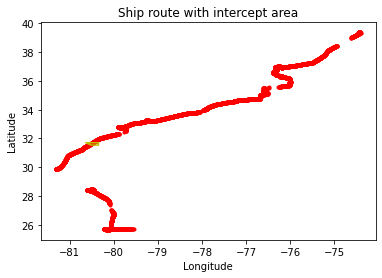

route of mmsi '368012130' intersects marine_conservation_area 'Georgia'


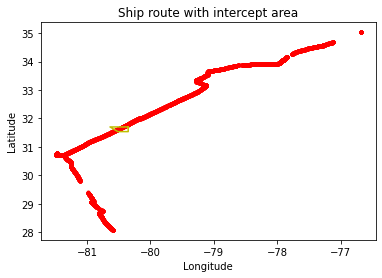

route of mmsi '367180970' intersects marine_conservation_area 'Georgia'


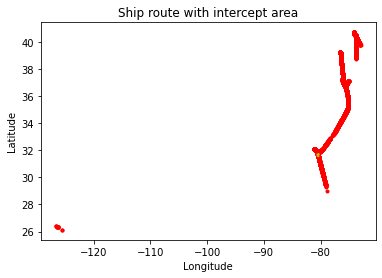

route of mmsi '266282000' intersects marine_conservation_area 'Georgia'


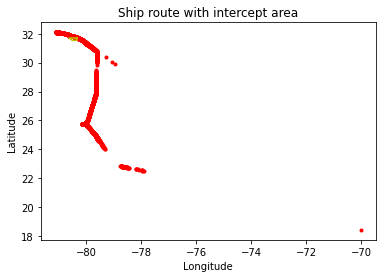

route of mmsi '636092826' intersects marine_conservation_area 'Georgia'


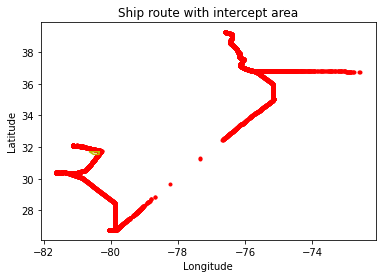

route of mmsi '246456000' intersects marine_conservation_area 'Georgia'


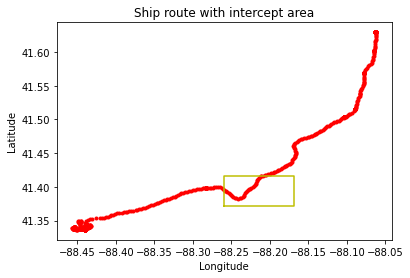

route of mmsi '367709890' intersects marine_conservation_area 'Demo'


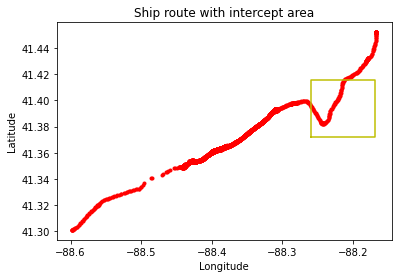

route of mmsi '367793880' intersects marine_conservation_area 'Demo'


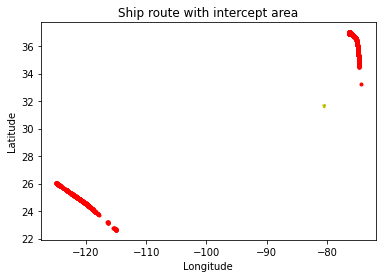

route of mmsi '636020994' intersects marine_conservation_area 'Georgia'


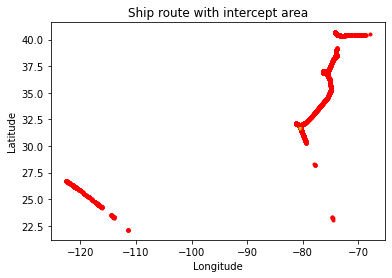

route of mmsi '357988000' intersects marine_conservation_area 'Georgia'


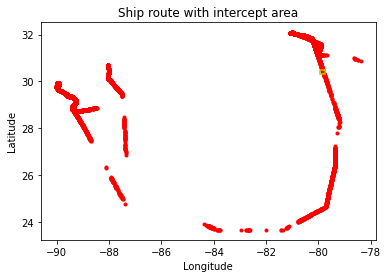

route of mmsi '305361000' intersects marine_conservation_area 'North Florida'


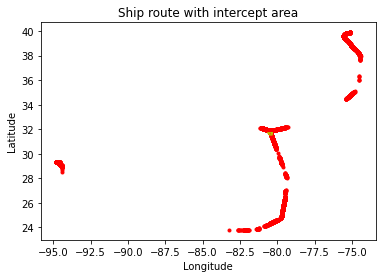

route of mmsi '538008004' intersects marine_conservation_area 'Georgia'


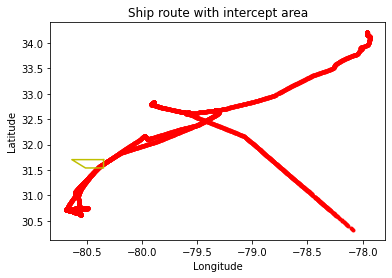

route of mmsi '431888000' intersects marine_conservation_area 'Georgia'


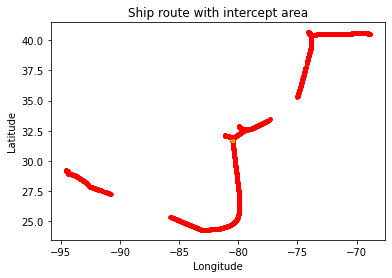

route of mmsi '338078000' intersects marine_conservation_area 'Georgia'


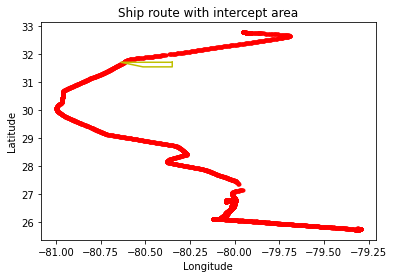

route of mmsi '319176900' intersects marine_conservation_area 'Georgia'


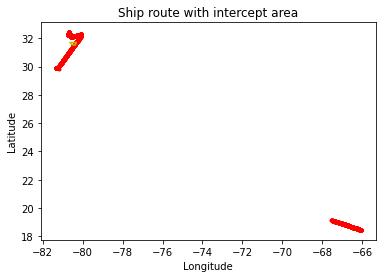

route of mmsi '367501880' intersects marine_conservation_area 'Georgia'


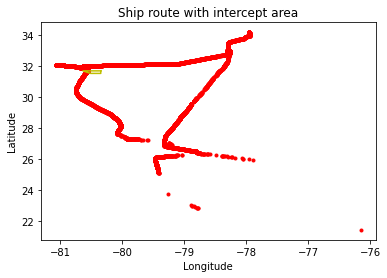

route of mmsi '538001682' intersects marine_conservation_area 'Georgia'


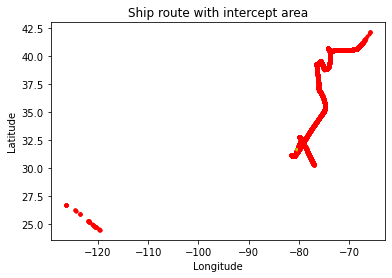

route of mmsi '351628000' intersects marine_conservation_area 'Georgia'


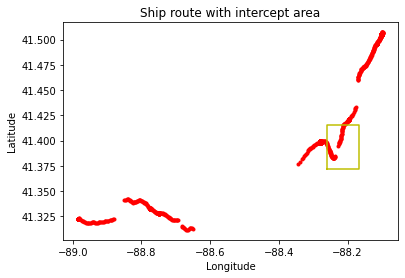

route of mmsi '369970472' intersects marine_conservation_area 'Demo'


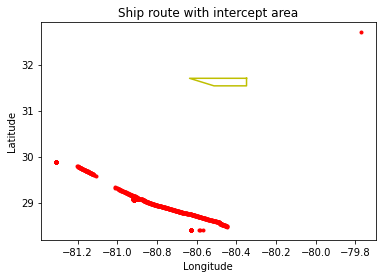

route of mmsi '368151070' intersects marine_conservation_area 'Georgia'


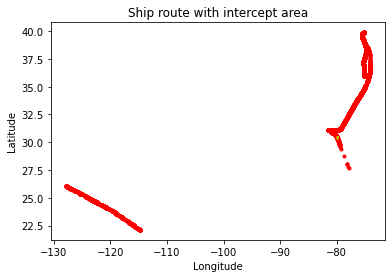

route of mmsi '441866000' intersects marine_conservation_area 'North Florida'


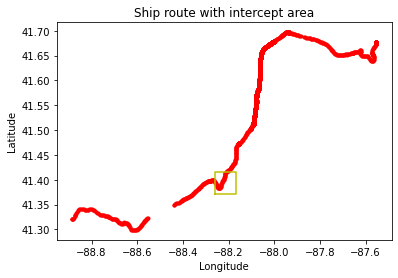

route of mmsi '368134280' intersects marine_conservation_area 'Demo'


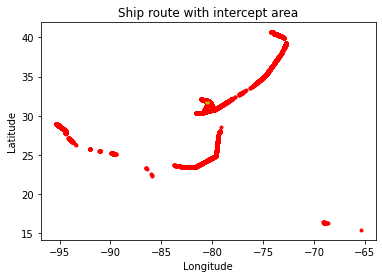

route of mmsi '247310400' intersects marine_conservation_area 'Georgia'


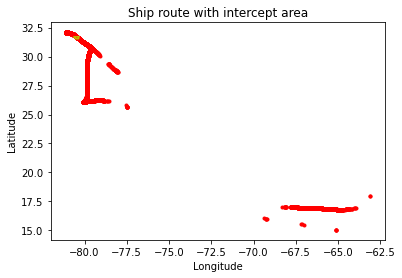

route of mmsi '209613000' intersects marine_conservation_area 'Georgia'


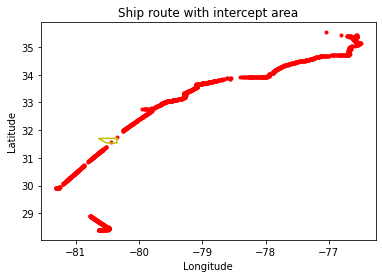

route of mmsi '367514840' intersects marine_conservation_area 'Georgia'


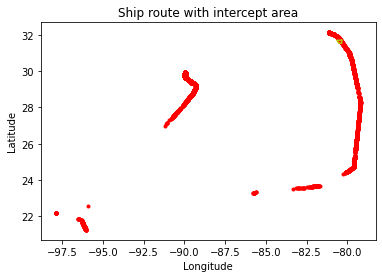

route of mmsi '370350000' intersects marine_conservation_area 'Georgia'


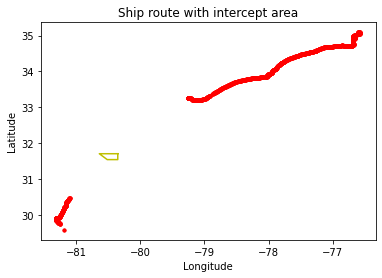

route of mmsi '338328097' intersects marine_conservation_area 'Georgia'


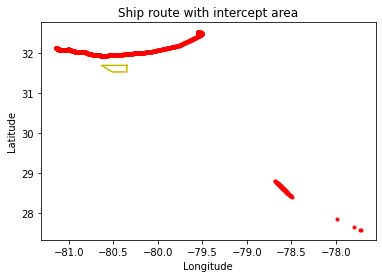

route of mmsi '372733000' intersects marine_conservation_area 'Georgia'


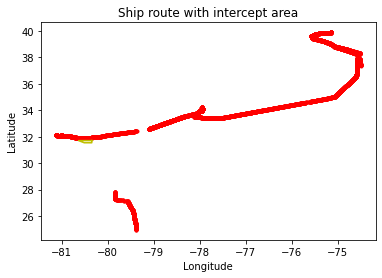

route of mmsi '248557000' intersects marine_conservation_area 'Georgia'


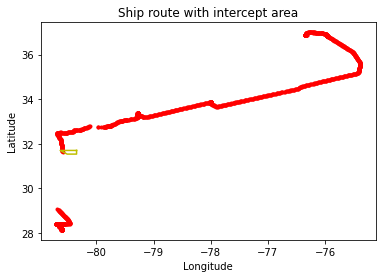

route of mmsi '338224239' intersects marine_conservation_area 'Georgia'


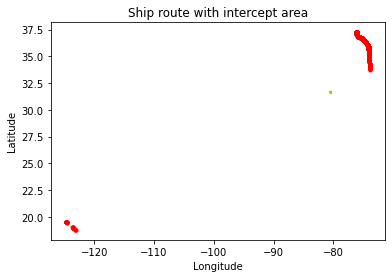

route of mmsi '431374000' intersects marine_conservation_area 'Georgia'


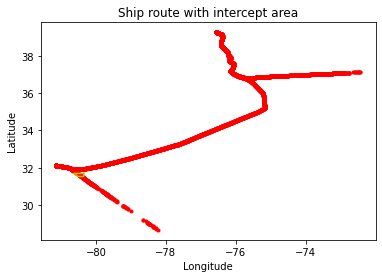

route of mmsi '266283000' intersects marine_conservation_area 'Georgia'


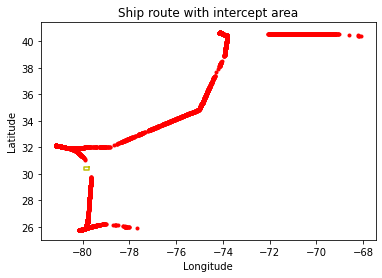

route of mmsi '228337900' intersects marine_conservation_area 'North Florida'


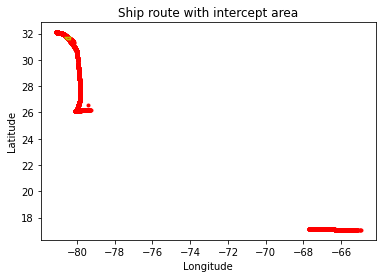

route of mmsi '304373000' intersects marine_conservation_area 'Georgia'


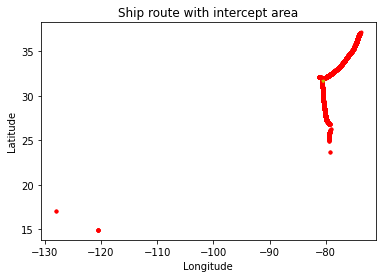

route of mmsi '244750715' intersects marine_conservation_area 'Georgia'


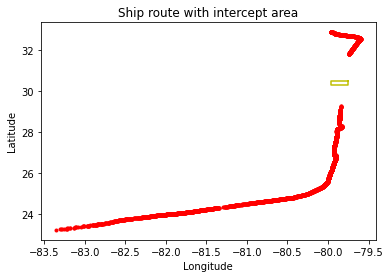

route of mmsi '357456000' intersects marine_conservation_area 'North Florida'


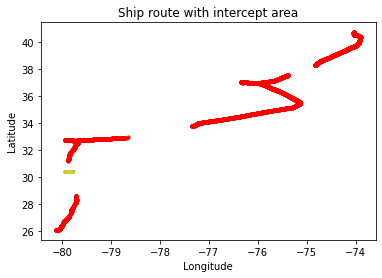

route of mmsi '367707610' intersects marine_conservation_area 'North Florida'


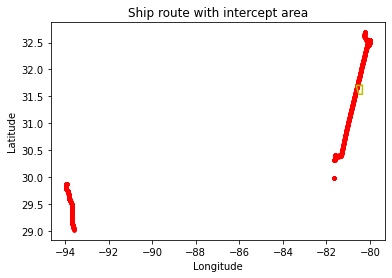

route of mmsi '367458640' intersects marine_conservation_area 'Georgia'


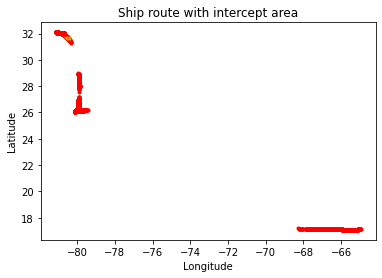

route of mmsi '304460000' intersects marine_conservation_area 'Georgia'


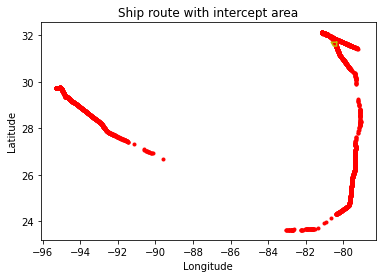

route of mmsi '538008724' intersects marine_conservation_area 'Georgia'


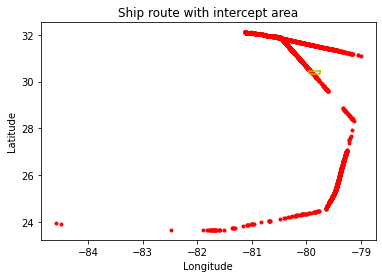

route of mmsi '215764000' intersects marine_conservation_area 'North Florida'


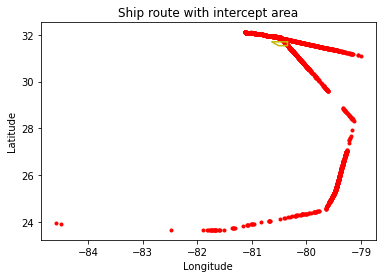

route of mmsi '215764000' intersects marine_conservation_area 'Georgia'


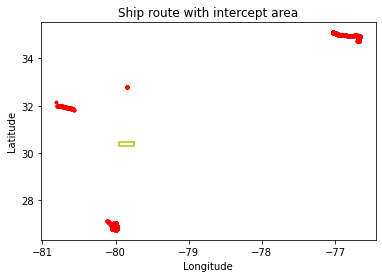

route of mmsi '368215160' intersects marine_conservation_area 'North Florida'


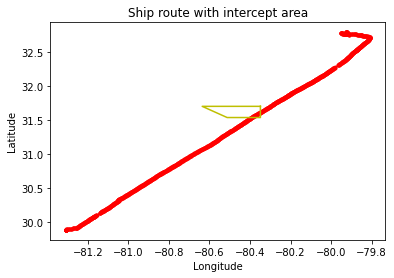

route of mmsi '338311973' intersects marine_conservation_area 'Georgia'


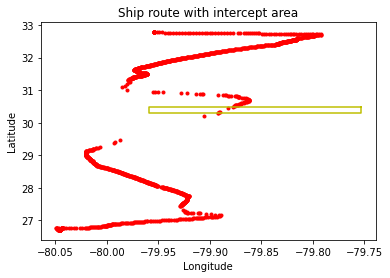

route of mmsi '338340589' intersects marine_conservation_area 'North Florida'


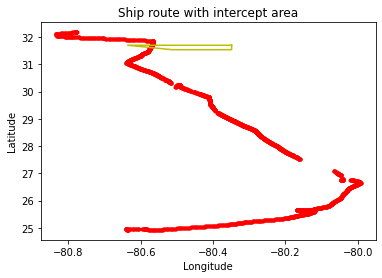

route of mmsi '368226460' intersects marine_conservation_area 'Georgia'


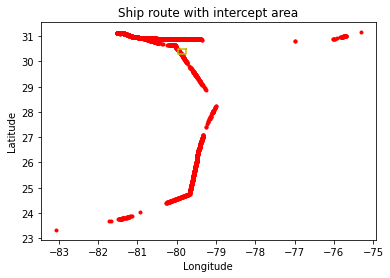

route of mmsi '353453000' intersects marine_conservation_area 'North Florida'


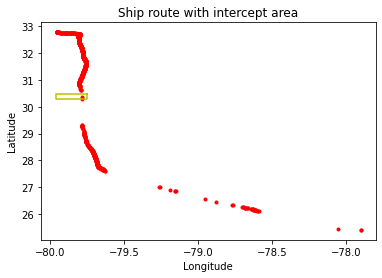

route of mmsi '232037842' intersects marine_conservation_area 'North Florida'


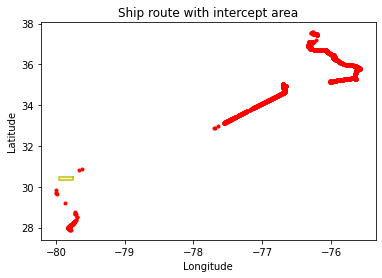

route of mmsi '232014046' intersects marine_conservation_area 'North Florida'


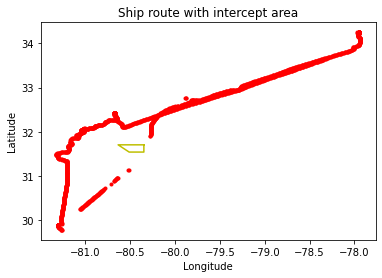

route of mmsi '367181030' intersects marine_conservation_area 'Georgia'


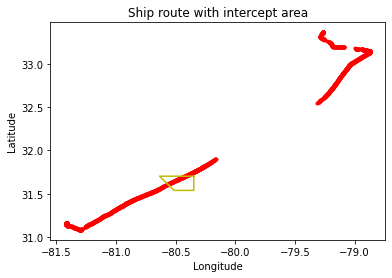

route of mmsi '367443610' intersects marine_conservation_area 'Georgia'


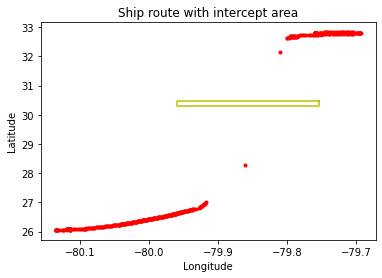

route of mmsi '338348305' intersects marine_conservation_area 'North Florida'


In [0]:
def draw_graph(route, area, name, mmsi):
  fig, ax1 = plt.subplots()
  ax1.scatter(x=[row['x'] for row in route], y=[row['y'] for row in route], marker='.', c='r')
  # ax1.plot([row[1] for row in marine_conservation_area], [row[0] for row in marine_conservation_area], c='y')
  ax1.plot([row[0] for row in area], [row[1] for row in area], c='y')
  ax1.set_title('Ship route with intercept area')
  ax1.set_xlabel('Longitude')
  ax1.set_ylabel('Latitude')
  plt.show()
  print("route of mmsi '%s' intersects marine_conservation_area '%s'" % (mmsi, name))
  save_plot(plt, mmsi, name)


routes = intersecting_fishing_matrix.select("route").collect()
areas = intersecting_fishing_matrix.select("coords").collect()
mmsis = intersecting_fishing_matrix.select("mmsi").collect()
names = intersecting_fishing_matrix.select("name").collect()
        
for idx, route in enumerate(routes):
  draw_graph(route[0], areas[idx][0], names[idx][0], mmsis[idx][0])
